In [1]:
import pandas as pd
import numpy as np
import tqdm
import os
import gc
import copy

import cv2
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.transforms.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

# Extract data and Divide into train/test

Here, we will extract all the information regarding train and test data

In [2]:
file_path = "C:\\UMD\\Sem 2\\MSML605 Computing Systems\\Homeworks\\Project\\CUB_200_2011"

images = pd.read_csv(f"{file_path}\\images.txt", 
                     sep=' ', 
                     names=['image_id', 'image_name'])
train_test = pd.read_csv(f"{file_path}\\train_test_split.txt", 
                     sep=' ', 
                     names=['image_id', 'is_training_image'])
classes = pd.read_csv(f"{file_path}\\classes.txt", 
                     sep=' ', 
                     names=['class_id', 'class_name'])
image_class_labels = pd.read_csv(f"{file_path}\\image_class_labels.txt", 
                     sep=' ', 
                     names=['image_id', 'class_id'])

bounding_boxes = pd.read_csv(f'{file_path}\\bounding_boxes.txt',
                             sep=' ',
                             names=['image_id', 'x', 'y', 'width', 'height'])
bounding_boxes = bounding_boxes.astype(int)
#Merging the information given
image_data = images.merge(train_test, on='image_id', how='inner')

labels_data = classes.merge(image_class_labels, on='class_id', how='inner')

image_data = image_data.merge(labels_data, on='image_id', how='inner')

image_data = image_data.merge(bounding_boxes, on='image_id', how='inner')
image_data

,image_id,image_name,is_training_image,class_id,class_name,x,y,width,height
0,1,001.Black_footed_Albatross/Black_Footed_Albatr...,0,1,001.Black_footed_Albatross,60,27,325,304
1,2,001.Black_footed_Albatross/Black_Footed_Albatr...,1,1,001.Black_footed_Albatross,139,30,153,264
2,3,001.Black_footed_Albatross/Black_Footed_Albatr...,0,1,001.Black_footed_Albatross,14,112,388,186
3,4,001.Black_footed_Albatross/Black_Footed_Albatr...,1,1,001.Black_footed_Albatross,112,90,255,242
4,5,001.Black_footed_Albatross/Black_Footed_Albatr...,1,1,001.Black_footed_Albatross,70,50,134,303
...,...,...,...,...,...,...,...,...,...
11783,11784,200.Common_Yellowthroat/Common_Yellowthroat_00...,1,200,200.Common_Yellowthroat,89,95,354,250
11784,11785,200.Common_Yellowthroat/Common_Yellowthroat_00...,0,200,200.Common_Yellowthroat,157,62,184,219
11785,11786,200.Common_Yellowthroat/Common_Yellowthroat_00...,0,200,200.Common_Yellowthroat,190,102,198,202
11786,11787,200.Common_Yellowthroat/Common_Yellowthroat_00...,1,200,200.Common_Yellowthroat,3,20,408,307


Now, we divide into train and test data using the information given

In [3]:
# Set the first 24 training values in each group to 0 
grouped = image_data[image_data['is_training_image'] == 1].groupby('class_name')
validation_indices = []

for name, group in grouped: 
    validation_indices.extend(group.index[24:])

# Set the first 24 values in each group to 0
image_data['is_validation_image'] = 0
image_data.loc[validation_indices, 'is_validation_image'] = 1
image_data['is_validation_image'].value_counts()

is_validation_image
0    10594
1     1194
Name: count, dtype: int64

In [4]:
#Split the data into training and test
train_indices = (image_data['is_training_image'] == 1) & (image_data['is_validation_image'] == 0)
training_data = image_data[train_indices].reset_index()
validation_data = image_data[image_data['is_validation_image'] == 1].reset_index()
test_data = image_data[image_data['is_training_image'] == 0].reset_index()

#Setting three sets of images: training, validation, and test
X_temp_train = []
X_temp_validation = []
X_temp_test = []
temp = [X_temp_train, X_temp_validation, X_temp_test]

for p, dataframe in enumerate([training_data, validation_data, test_data]):
    #Get the paths for the images
    paths = 'CUB_200_2011/images/' + np.array(dataframe['image_name'])
    
    #Get the image arrays
    for i, img in tqdm.tqdm(enumerate(paths), total=dataframe.shape[0]):
        image = cv2.imread(img)
        x, y, width, height = dataframe.loc[i, ['x', 'y', 'width', 'height']]
        temp[p].append(image[y:y+height, x:x+width, :])
    
len(X_temp_train), len(X_temp_validation), len(X_temp_test)

100%|██████████| 5794/5794 [00:42<00:00, 137.10it/s]


(4800, 1194, 5794)

# Data Preprocessing

Padding all to square and then reshaping all to 224x224

In [5]:
def convert_to_PIL(image):
    return Image.fromarray(image)

# Define the transformation pipeline
transform = transforms.Compose([
    convert_to_PIL,
    # transforms.Resize(256),  # Resize the shorter side to 256, preserving aspect ratio
    # transforms.CenterCrop(224),  # Center crop to 224x224
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


final_image_size = (224, 224)


In [6]:
X_train, X_validation, X_test = [], [], []
for i, img in tqdm.tqdm(enumerate(X_temp_train), total=len(X_temp_train)):
    X_train.append(transform(img))

for i, img in tqdm.tqdm(enumerate(X_temp_validation), total=len(X_temp_validation)):
    X_validation.append(transform(img))

for i, img in tqdm.tqdm(enumerate(X_temp_test), total=len(X_temp_test)):
    X_test.append(transform(img))

100%|██████████| 5794/5794 [00:28<00:00, 205.19it/s]


In [7]:
y_train = np.array(image_data[train_indices]['class_id']) - 1

In [8]:
# train_transform = transforms.Compose([
#     convert_to_PIL,
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.RandomRotation(10),
#     transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.RandomErasing(inplace=True),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

# for i, img in tqdm.tqdm(enumerate(X_temp_train), total=len(X_temp_train)):
#     X_train.append(train_transform(img))

# y_train = np.array(image_data[train_indices]['class_id']) - 1
# y_train = np.concatenate([y_train, y_train])

In [9]:
# Convert the list of tensors to a 4D tensor (N, H, W, C)
X_train = torch.stack(X_train)   
print("Train done")

X_validation = torch.stack(X_validation) 
print("Validation done")

X_test = torch.stack(X_test)
print("Test done")   

print(X_train.shape, X_validation.shape, X_test.shape)

Train done
Validation done
Test done
torch.Size([4800, 3, 224, 224]) torch.Size([1194, 3, 224, 224]) torch.Size([5794, 3, 224, 224])


Setting labels

In [10]:
# Set the labels for training, validation and test
# y_validation = np.array(image_data[image_data['is_validation_image'] == 1]['class_id']) - 1
y_validation = np.array(image_data[image_data['is_validation_image'] == 1]['class_id']) - 1
y_test = np.array(image_data[image_data['is_training_image'] == 0]['class_id']) - 1

# dtype=torch.float, torch.long
y_train = torch.Tensor(y_train)
y_validation = torch.Tensor(y_validation).long()
y_test = torch.Tensor(y_test).long()
len(y_train), len(y_validation), len(y_test)

(4800, 1194, 5794)

Creating DataLoader

In [11]:
TrainDataset = data.TensorDataset(X_train, y_train)
ValidationDataset = data.TensorDataset(X_validation, y_validation)
TestDataset = data.TensorDataset(X_test, y_test)

batch_size = 2
TrainLoader = data.DataLoader(dataset=TrainDataset, batch_size=batch_size,
                               shuffle=True, num_workers=4, pin_memory=True)

ValidationLoader = data.DataLoader(dataset=ValidationDataset, batch_size=batch_size,
                               shuffle=True, num_workers=4, pin_memory=True)

TestLoader = data.DataLoader(dataset=TestDataset, batch_size=batch_size,
                               shuffle=True, num_workers=4, pin_memory=True)

len(TrainDataset), len(ValidationDataset), len(TestDataset)

(4800, 1194, 5794)

In [12]:
gc.collect()
torch.cuda.empty_cache()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.535425].


GroundTruth:  41.0 1.0


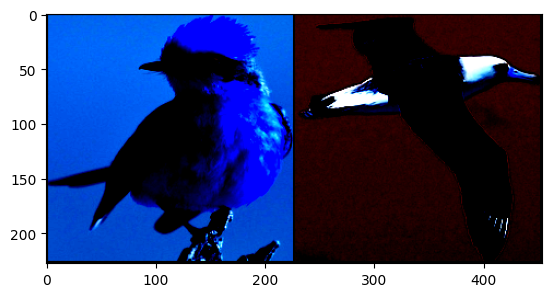

In [13]:
dataiter = iter(TrainLoader)
images, labels = next(dataiter)

# print images
plt.imshow(torchvision.utils.make_grid(images, nrow=10).permute(1, 2, 0))
print('GroundTruth: ', ' '.join(f'{labels[j]}' for j in range(2)))

Calculating accuracy function

In [14]:
def calculate_accuracy(model, loader, data_type='training'):
    model.eval() # Set model to evaluation mode

    correct = total = 0
    with torch.no_grad():
        for input_data in tqdm.tqdm(loader, total=len(loader)):
            # Move images to device (GPU if available)
            images, labels = input_data[0].to(device), input_data[1].to(device)
            
            #Predict values and convert to non-onehot vector
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)

            #For training, there will be onehot vector, so convert from onehot
            if data_type == 'training': 
                _, labels = torch.max(labels.data, 1)
            
            #Compare with ground truth
            correct += (predicted == labels).sum().item()

        print(f'Accuracy of the network on the {len(loader)} {data_type} images: {100 * correct / total}')
    return 100 * correct/total
    


# Training

In [15]:
# Load the pretrained ResNet-50 model
NewModel = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Modify the final fully connected layers
num_classes = 200  # Replace with the number of bird species

# Redefine the fc layers
NewModel.fc = nn.Sequential(
    nn.Linear(NewModel.fc.in_features, NewModel.fc.in_features),
    nn.ReLU(),
    nn.Linear(NewModel.fc.in_features, 200),
)
# NewModel.fc = nn.Linear(NewModel.fc.in_features, num_classes)

# Freeze all layers except the new fully connected layers
for param in NewModel.parameters():
    param.requires_grad = False

for param in NewModel.fc.parameters():
    param.requires_grad = True


# optimizer = optim.Adam(params=NewModel.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()


NewModel.to(device)


c:\UMD\.venv\Lib\site-packages\torch\nn\modules\module.py:1159: UserWarning: expandable_segments not supported on this platform (Triggered internally at ..\c10/cuda/CUDAAllocatorConfig.h:28.)
  return t.to(


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
training_loss = []
training_accuracy = []
validation_accuracy = []

## Check Initial Loss

log(C) for softmax for C classes

In [17]:
def calculate_loss(model, loader, criterion):
    model.eval() # Set model to evaluation mode

    running_loss = 0
    with torch.no_grad():
        for input_data in tqdm.tqdm(loader, total=len(loader)):
            # Move images to device (GPU if available)
            images, labels = input_data[0].to(device), input_data[1].to(device)
            
            #Predict values and convert to non-onehot vector
            outputs = model(images)
            loss = criterion(outputs, labels.long())
            running_loss += loss.item()

    return running_loss / len(loader)

calculate_loss(NewModel, TrainLoader, criterion)


100%|██████████| 2400/2400 [00:24<00:00, 99.88it/s] 


5.301470051805178

In [18]:
- np.log(1/200)

5.298317366548036

We can observe that the loss is nearly as expected. This means that our model is not making any mistake.

The loss should be $log(C)$ where $C$ is the number of classes.

The reason is that the cross entropy is defined as 
$$\frac{1}{N}\sum_{i = 1}^{N}-y_i log(p_i)$$ 
where $y_i = 1$ for correct $i$ and the probability $p_i = \frac{1}{C}$

## Overfit a small sample

We need to get 100% training accuracy on a small sample of training data (5 - 10 minibatches). No weight initialization and regularization.

Bad initialization conditions
- If loss is not going down, LR is too low 
- If loss explodes to `np.inf` or `NaN`, LR is too high

In [22]:
def overfit_model(NewModel, Loader, optimizer, criterion, num_epochs=30):
    training_loss = []
    training_accuracy = []

    for epoch in range(num_epochs):
        NewModel.train()

        running_loss = 0    
        for input_data, labels in tqdm.tqdm(Loader, total=len(Loader)):
            # Forward pass
            labels, input_data = labels.to(device), input_data.to(device)
            output = NewModel(input_data)
            
            # Compute loss
            loss = criterion(output, labels.long())
            running_loss += loss.item()
            # Backward pass
            optimizer.zero_grad()  # Zero the gradients
            loss.backward()  # Compute gradients
            optimizer.step()  # Update weights
            
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(Loader)}')
        training_loss.append(running_loss / len(Loader))
        training_accuracy.append(calculate_accuracy(NewModel, Loader, data_type='train'))
    
    return training_loss, training_accuracy

def plot_training_plots(training_loss, training_accuracy):
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    ax[0].plot(range(len(training_loss)), training_loss)
    ax[1].plot(range(len(training_accuracy)), training_accuracy, label='Training Accuracy')
    ax[1].grid()
    ax[0].grid()
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Training Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    plt.show()

In [23]:
SampleDataset = data.TensorDataset(X_train[:batch_size * 10], y_train[:batch_size * 10])

SampleLoader = data.DataLoader(dataset=SampleDataset, batch_size=batch_size,
                               shuffle=True, num_workers=4, pin_memory=True)
len(SampleLoader)

10

Optimizer: SGD


100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


Epoch [1/10], Loss: 5.254129648208618


100%|██████████| 10/10 [00:04<00:00,  2.50it/s]


Accuracy of the network on the 10 train images: 15.0


100%|██████████| 10/10 [00:03<00:00,  2.75it/s]


Epoch [2/10], Loss: 5.181721830368042


100%|██████████| 10/10 [00:03<00:00,  2.90it/s]


Accuracy of the network on the 10 train images: 70.0


100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Epoch [3/10], Loss: 5.097325038909912


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:03<00:00,  2.79it/s]


Epoch [4/10], Loss: 5.029108142852783


100%|██████████| 10/10 [00:04<00:00,  2.43it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:04<00:00,  2.45it/s]


Epoch [5/10], Loss: 4.964022254943847


100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


Epoch [6/10], Loss: 4.864399147033692


100%|██████████| 10/10 [00:02<00:00,  3.84it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  3.62it/s]


Epoch [7/10], Loss: 4.738603115081787


100%|██████████| 10/10 [00:02<00:00,  3.61it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


Epoch [8/10], Loss: 4.675319242477417


100%|██████████| 10/10 [00:03<00:00,  2.73it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


Epoch [9/10], Loss: 4.558901405334472


100%|██████████| 10/10 [00:02<00:00,  3.69it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


Epoch [10/10], Loss: 4.426292037963867


100%|██████████| 10/10 [00:04<00:00,  2.23it/s]

Accuracy of the network on the 10 train images: 100.0


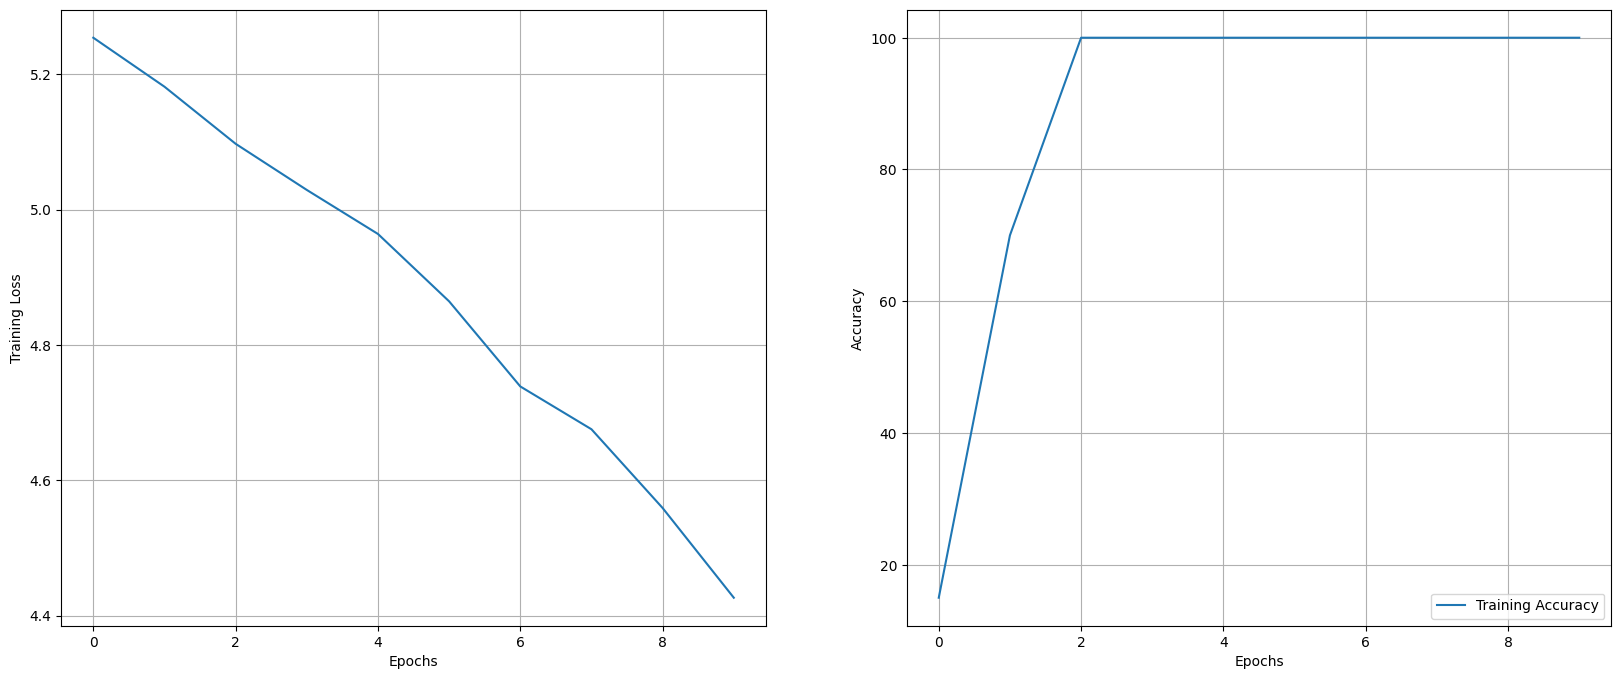

Optimizer: SGD+Momentum


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


Epoch [1/10], Loss: 4.242005634307861


100%|██████████| 10/10 [00:03<00:00,  2.77it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:04<00:00,  2.31it/s]


Epoch [2/10], Loss: 3.475042796134949


100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:04<00:00,  2.26it/s]


Epoch [3/10], Loss: 1.9534042119979858


100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:03<00:00,  2.89it/s]


Epoch [4/10], Loss: 0.6780839443206788


100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:04<00:00,  2.31it/s]


Epoch [5/10], Loss: 0.11177184623666107


100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:04<00:00,  2.42it/s]


Epoch [6/10], Loss: 0.05259172166697681


100%|██████████| 10/10 [00:04<00:00,  2.31it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


Epoch [7/10], Loss: 0.03362622782588005


100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:04<00:00,  2.25it/s]


Epoch [8/10], Loss: 0.06224291403777897


100%|██████████| 10/10 [00:03<00:00,  2.59it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


Epoch [9/10], Loss: 0.0317691148375161


100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


Epoch [10/10], Loss: 0.009118055313592777


100%|██████████| 10/10 [00:06<00:00,  1.66it/s]

Accuracy of the network on the 10 train images: 100.0


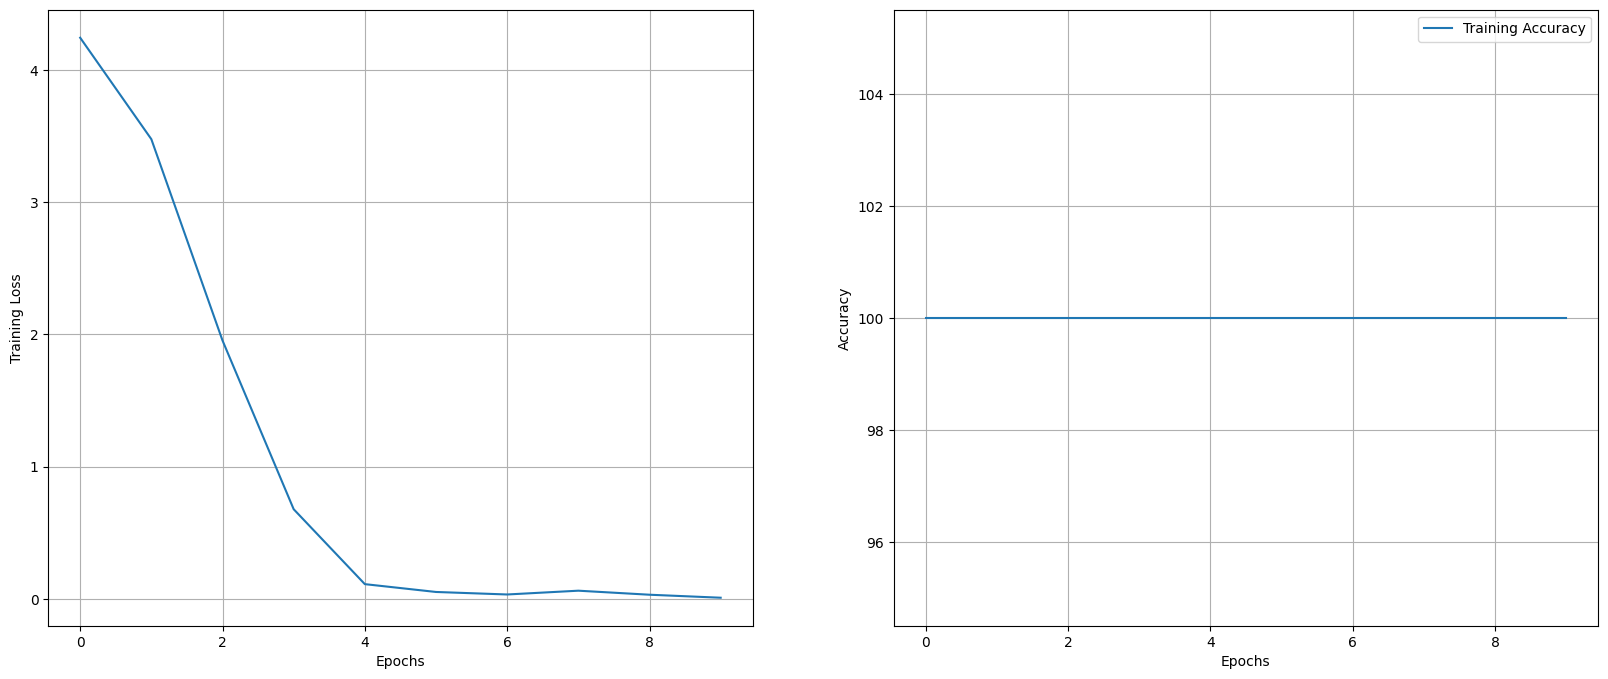

Optimizer: AdamW


100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


Epoch [1/10], Loss: 0.002032936188325607


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


Epoch [2/10], Loss: 0.0


100%|██████████| 10/10 [00:19<00:00,  1.98s/it]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


Epoch [3/10], Loss: 0.0


100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


Epoch [4/10], Loss: 0.0


100%|██████████| 10/10 [00:17<00:00,  1.73s/it]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:18<00:00,  1.89s/it]


Epoch [5/10], Loss: 0.0


100%|██████████| 10/10 [00:20<00:00,  2.10s/it]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:21<00:00,  2.17s/it]


Epoch [6/10], Loss: 0.0


100%|██████████| 10/10 [00:25<00:00,  2.50s/it]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


Epoch [7/10], Loss: 0.0


100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


Epoch [8/10], Loss: 0.0


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


Epoch [9/10], Loss: 0.0


100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


Epoch [10/10], Loss: 0.0


100%|██████████| 10/10 [00:04<00:00,  2.15it/s]

Accuracy of the network on the 10 train images: 100.0


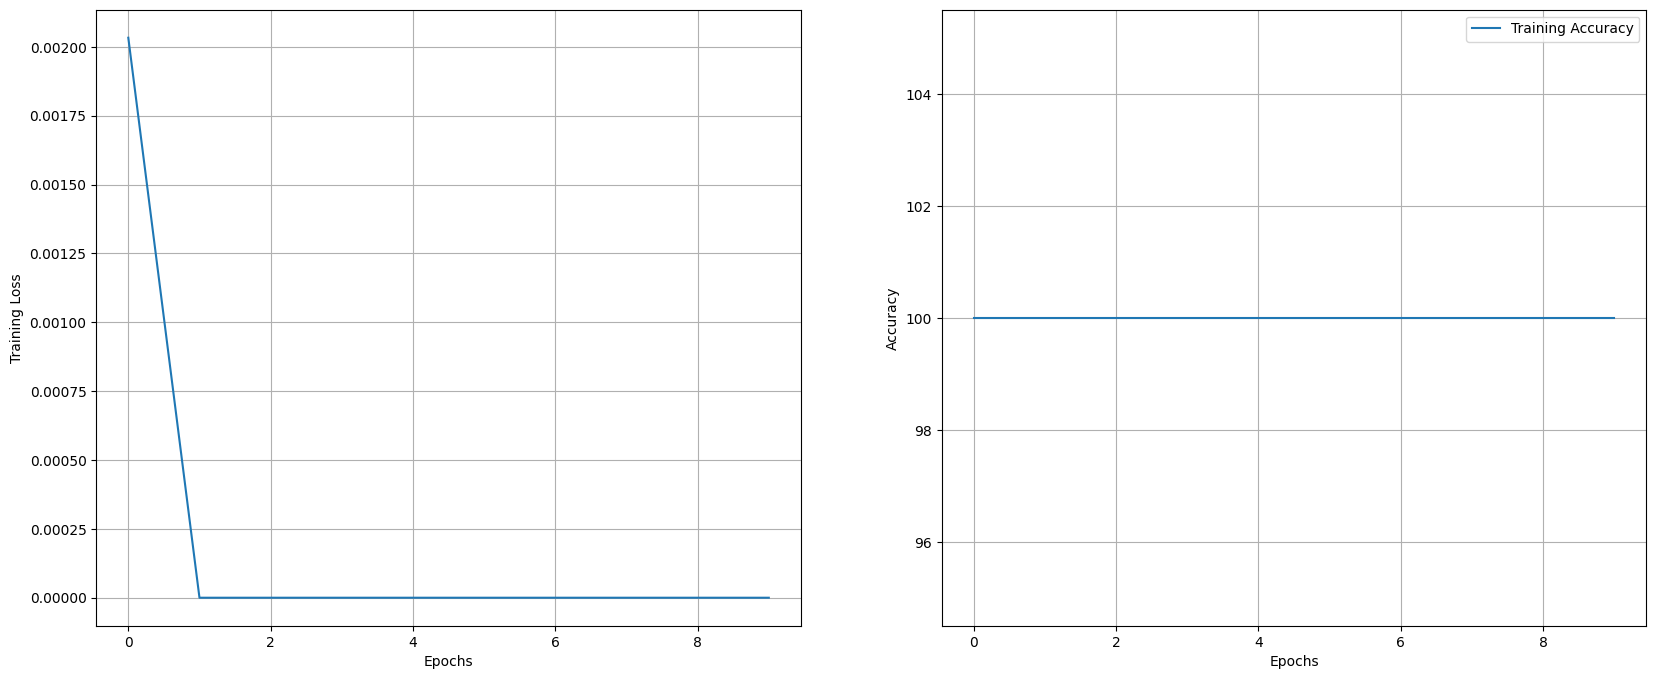

Optimizer: Adam


100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


Epoch [1/10], Loss: 0.0


100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


Epoch [2/10], Loss: 0.0


100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Epoch [3/10], Loss: 0.0


100%|██████████| 10/10 [00:04<00:00,  2.21it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:04<00:00,  2.30it/s]


Epoch [4/10], Loss: 0.0


100%|██████████| 10/10 [00:04<00:00,  2.35it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


Epoch [5/10], Loss: 0.0


100%|██████████| 10/10 [00:04<00:00,  2.48it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:04<00:00,  2.49it/s]


Epoch [6/10], Loss: 0.0


100%|██████████| 10/10 [00:03<00:00,  2.57it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:04<00:00,  2.45it/s]


Epoch [7/10], Loss: 0.0


100%|██████████| 10/10 [00:04<00:00,  2.28it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


Epoch [8/10], Loss: 0.0


100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


Epoch [9/10], Loss: 0.0


100%|██████████| 10/10 [00:04<00:00,  2.22it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


Epoch [10/10], Loss: 0.0


100%|██████████| 10/10 [00:04<00:00,  2.18it/s]

Accuracy of the network on the 10 train images: 100.0


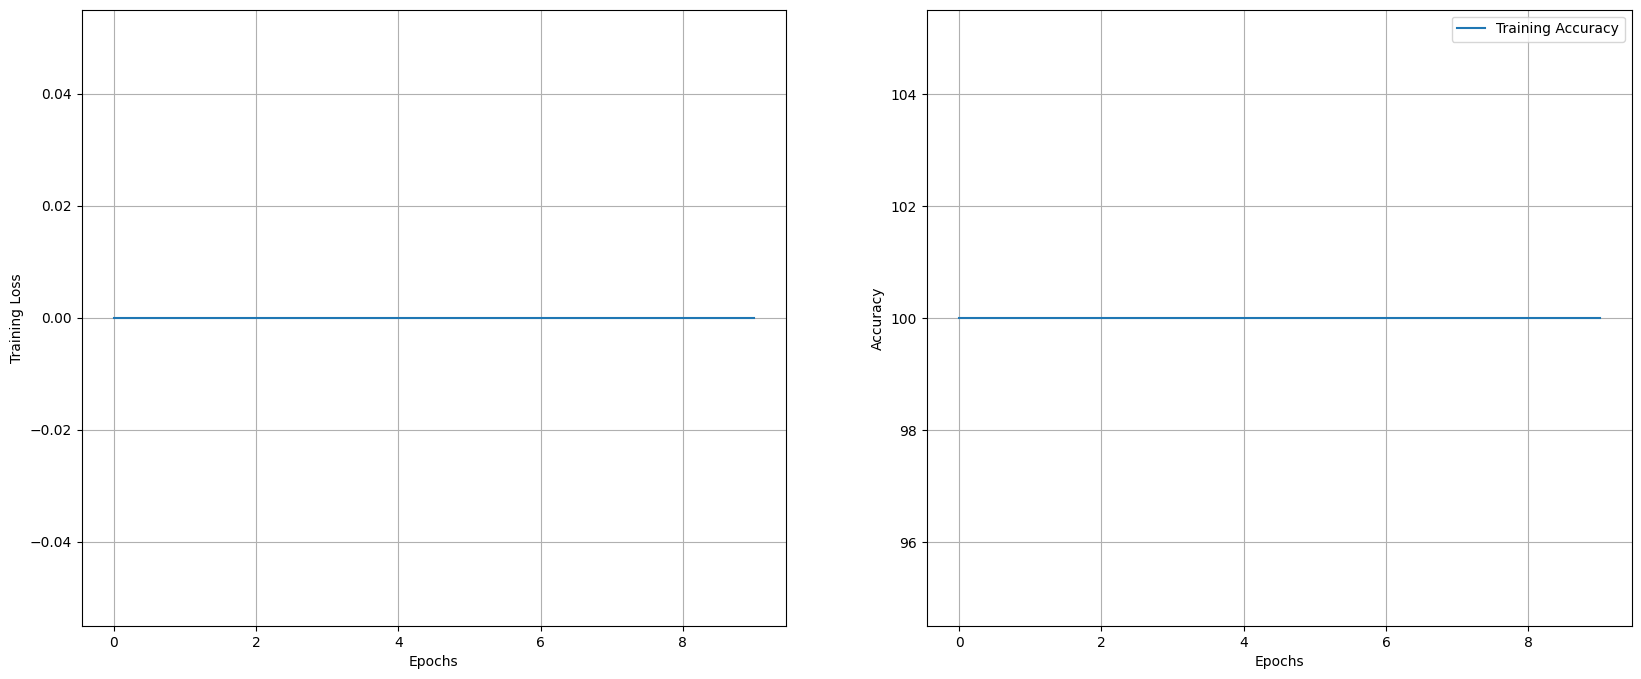

In [24]:
models_copy = [copy.deepcopy(NewModel)] * 4

optimizers = {
    'SGD': optim.SGD(params=models_copy[0].parameters(), lr=1e-3, weight_decay=0),
    'SGD+Momentum': optim.SGD(params=models_copy[1].parameters(), lr=1e-3, weight_decay=0, momentum=0.9),
    'AdamW': optim.AdamW(params=models_copy[2].parameters(), lr=1e-3),
    'Adam': optim.Adam(params=models_copy[3].parameters(), lr=1e-3)
}


optimizer_results = {}
for i, optimizer in enumerate(optimizers):
    print(f'Optimizer: {optimizer}')
    training_loss = []
    training_accuracy = []
    
    criterion = nn.CrossEntropyLoss()
    
    training_loss, training_accuracy = overfit_model(models_copy[i], SampleLoader, 
                                                     optimizers[optimizer], criterion, 
                                                     num_epochs=10)
    optimizer_results[optimizer] = (training_loss, training_accuracy)
    
    plot_training_plots(training_loss, training_accuracy)

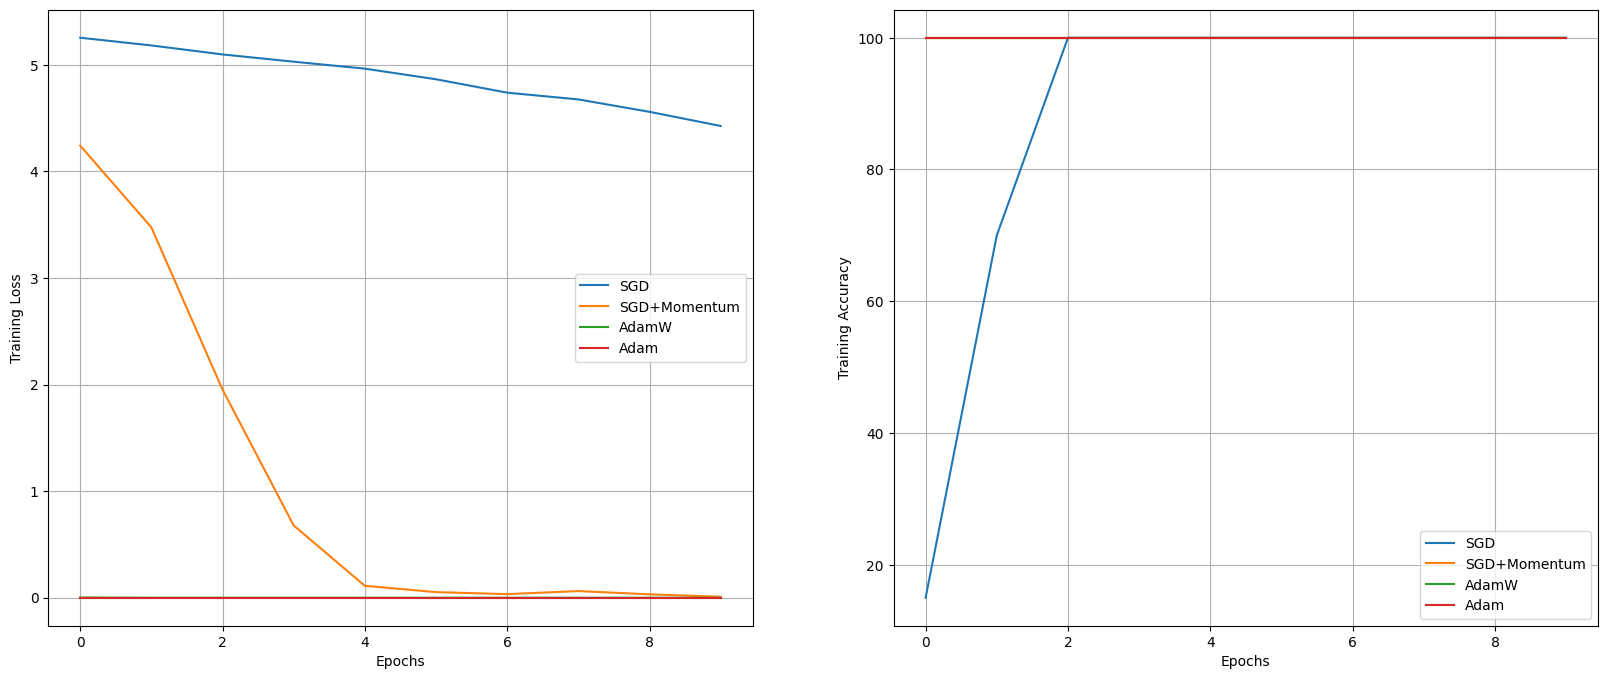

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
for optimizer in optimizer_results:
    training_loss, training_accuracy = optimizer_results[optimizer]
    ax[0].plot(range(len(training_loss)), training_loss, label=optimizer)
    ax[1].plot(range(len(training_accuracy)), training_accuracy, label=optimizer)

for i in range(2):
    ax[i].grid()
    ax[i].set_xlabel('Epochs')
    ax[i].legend()

ax[0].set_ylabel('Training Loss')
ax[1].set_ylabel('Training Accuracy')

plt.show()

## Find Learning Rate that makes loss go down

Use the architecture from the previous step and use all training data, turn on small weight decay, find learning rate that makes the loss drop significantly (within 100 iterations)

Good learning rates: 1e-1, 1e-2, 1e-3, 1e-4

0.1


100%|██████████| 2400/2400 [02:47<00:00, 14.31it/s]


Epoch [1/10], Loss: 14.421459960341453


100%|██████████| 2400/2400 [00:47<00:00, 50.84it/s] 


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [02:14<00:00, 17.79it/s]


Epoch [2/10], Loss: 8.224155049324036


100%|██████████| 2400/2400 [01:31<00:00, 26.21it/s]


Accuracy of the network on the 2400 train images: 0.5208333333333334


100%|██████████| 2400/2400 [01:21<00:00, 29.32it/s]


Epoch [3/10], Loss: 10.825397508839766


100%|██████████| 2400/2400 [00:34<00:00, 68.72it/s] 


Accuracy of the network on the 2400 train images: 0.5416666666666666


100%|██████████| 2400/2400 [00:45<00:00, 53.04it/s]


Epoch [4/10], Loss: 12.232847635646662


100%|██████████| 2400/2400 [00:26<00:00, 90.11it/s] 


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:36<00:00, 66.05it/s]


Epoch [5/10], Loss: 13.017413719793161


100%|██████████| 2400/2400 [00:24<00:00, 97.24it/s] 


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:36<00:00, 66.24it/s]


Epoch [6/10], Loss: 11.906091262300809


100%|██████████| 2400/2400 [00:24<00:00, 98.94it/s] 


Accuracy of the network on the 2400 train images: 0.4791666666666667


100%|██████████| 2400/2400 [00:32<00:00, 73.59it/s]


Epoch [7/10], Loss: 12.55720398883025


100%|██████████| 2400/2400 [00:22<00:00, 108.78it/s]


Accuracy of the network on the 2400 train images: 0.5416666666666666


100%|██████████| 2400/2400 [00:31<00:00, 75.70it/s]


Epoch [8/10], Loss: 12.295285102625687


100%|██████████| 2400/2400 [00:21<00:00, 112.10it/s]


Accuracy of the network on the 2400 train images: 0.3541666666666667


100%|██████████| 2400/2400 [00:31<00:00, 76.82it/s]


Epoch [9/10], Loss: 12.77398497591416


100%|██████████| 2400/2400 [00:21<00:00, 111.48it/s]


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:31<00:00, 75.37it/s]


Epoch [10/10], Loss: 12.364310780366262


100%|██████████| 2400/2400 [00:21<00:00, 109.88it/s]


Accuracy of the network on the 2400 train images: 0.4166666666666667
0.01


100%|██████████| 2400/2400 [00:31<00:00, 75.69it/s]


Epoch [1/10], Loss: 5.421770569086075


100%|██████████| 2400/2400 [00:23<00:00, 104.25it/s]


Accuracy of the network on the 2400 train images: 0.5416666666666666


100%|██████████| 2400/2400 [00:31<00:00, 76.61it/s]


Epoch [2/10], Loss: 5.353078898588817


100%|██████████| 2400/2400 [00:23<00:00, 102.89it/s]


Accuracy of the network on the 2400 train images: 0.6666666666666666


100%|██████████| 2400/2400 [00:31<00:00, 76.18it/s]


Epoch [3/10], Loss: 5.380447839200497


100%|██████████| 2400/2400 [00:22<00:00, 104.99it/s]


Accuracy of the network on the 2400 train images: 0.9166666666666666


100%|██████████| 2400/2400 [00:30<00:00, 77.48it/s]


Epoch [4/10], Loss: 5.370654792288939


100%|██████████| 2400/2400 [00:22<00:00, 105.25it/s]


Accuracy of the network on the 2400 train images: 0.6041666666666666


100%|██████████| 2400/2400 [00:31<00:00, 77.16it/s]


Epoch [5/10], Loss: 5.3620494302113855


100%|██████████| 2400/2400 [00:22<00:00, 106.27it/s]


Accuracy of the network on the 2400 train images: 1.2708333333333333


100%|██████████| 2400/2400 [00:30<00:00, 77.69it/s]


Epoch [6/10], Loss: 5.384017245968183


100%|██████████| 2400/2400 [00:22<00:00, 106.93it/s]


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:31<00:00, 76.16it/s]


Epoch [7/10], Loss: 5.3714448787768685


100%|██████████| 2400/2400 [00:22<00:00, 107.11it/s]


Accuracy of the network on the 2400 train images: 1.0833333333333333


100%|██████████| 2400/2400 [00:33<00:00, 71.60it/s]


Epoch [8/10], Loss: 5.377478673458099


100%|██████████| 2400/2400 [00:22<00:00, 108.37it/s]


Accuracy of the network on the 2400 train images: 0.9583333333333334


100%|██████████| 2400/2400 [00:32<00:00, 74.44it/s]


Epoch [9/10], Loss: 5.37604474524657


100%|██████████| 2400/2400 [00:23<00:00, 104.04it/s]


Accuracy of the network on the 2400 train images: 0.5625


100%|██████████| 2400/2400 [00:32<00:00, 74.65it/s]


Epoch [10/10], Loss: 5.365362166464329


100%|██████████| 2400/2400 [00:23<00:00, 102.61it/s]


Accuracy of the network on the 2400 train images: 0.7083333333333334
0.001


100%|██████████| 2400/2400 [00:31<00:00, 76.32it/s]


Epoch [1/10], Loss: 5.315859860777855


100%|██████████| 2400/2400 [00:22<00:00, 106.13it/s]


Accuracy of the network on the 2400 train images: 0.5833333333333334


100%|██████████| 2400/2400 [00:31<00:00, 75.03it/s]


Epoch [2/10], Loss: 5.295910007953644


100%|██████████| 2400/2400 [00:23<00:00, 104.22it/s]


Accuracy of the network on the 2400 train images: 0.7708333333333334


100%|██████████| 2400/2400 [00:31<00:00, 76.59it/s]


Epoch [3/10], Loss: 5.1686038974920905


100%|██████████| 2400/2400 [00:22<00:00, 104.95it/s]


Accuracy of the network on the 2400 train images: 1.3958333333333333


100%|██████████| 2400/2400 [00:31<00:00, 76.29it/s]


Epoch [4/10], Loss: 5.025496062835058


100%|██████████| 2400/2400 [00:22<00:00, 105.04it/s]


Accuracy of the network on the 2400 train images: 2.0833333333333335


100%|██████████| 2400/2400 [00:31<00:00, 75.06it/s]


Epoch [5/10], Loss: 4.847121002376079


100%|██████████| 2400/2400 [00:22<00:00, 107.73it/s]


Accuracy of the network on the 2400 train images: 3.4583333333333335


100%|██████████| 2400/2400 [00:31<00:00, 76.38it/s]


Epoch [6/10], Loss: 4.648404208322366


100%|██████████| 2400/2400 [00:23<00:00, 101.60it/s]


Accuracy of the network on the 2400 train images: 6.479166666666667


100%|██████████| 2400/2400 [00:32<00:00, 73.00it/s]


Epoch [7/10], Loss: 4.338910919924577


100%|██████████| 2400/2400 [00:22<00:00, 105.93it/s]


Accuracy of the network on the 2400 train images: 11.354166666666666


100%|██████████| 2400/2400 [00:32<00:00, 73.07it/s]


Epoch [8/10], Loss: 4.035002708807587


100%|██████████| 2400/2400 [00:23<00:00, 100.06it/s]


Accuracy of the network on the 2400 train images: 18.458333333333332


100%|██████████| 2400/2400 [00:30<00:00, 78.31it/s]


Epoch [9/10], Loss: 3.7302087631821634


100%|██████████| 2400/2400 [00:22<00:00, 108.39it/s]


Accuracy of the network on the 2400 train images: 20.625


100%|██████████| 2400/2400 [00:29<00:00, 80.06it/s]


Epoch [10/10], Loss: 3.458774020324151


100%|██████████| 2400/2400 [00:22<00:00, 108.29it/s]


Accuracy of the network on the 2400 train images: 26.1875
0.0001


100%|██████████| 2400/2400 [00:30<00:00, 79.69it/s]


Epoch [1/10], Loss: 5.247634943127633


100%|██████████| 2400/2400 [00:24<00:00, 98.30it/s] 


Accuracy of the network on the 2400 train images: 6.625


100%|██████████| 2400/2400 [00:31<00:00, 75.59it/s]


Epoch [2/10], Loss: 4.700352418621381


100%|██████████| 2400/2400 [00:23<00:00, 101.29it/s]


Accuracy of the network on the 2400 train images: 14.916666666666666


100%|██████████| 2400/2400 [00:32<00:00, 73.36it/s]


Epoch [3/10], Loss: 4.172766754478216


100%|██████████| 2400/2400 [00:23<00:00, 101.09it/s]


Accuracy of the network on the 2400 train images: 20.75


100%|██████████| 2400/2400 [00:32<00:00, 73.66it/s]


Epoch [4/10], Loss: 3.715393418222666


100%|██████████| 2400/2400 [00:22<00:00, 106.67it/s]


Accuracy of the network on the 2400 train images: 37.041666666666664


100%|██████████| 2400/2400 [00:31<00:00, 76.21it/s]


Epoch [5/10], Loss: 3.3847857467085123


100%|██████████| 2400/2400 [00:23<00:00, 103.47it/s]


Accuracy of the network on the 2400 train images: 40.666666666666664


100%|██████████| 2400/2400 [00:32<00:00, 72.80it/s]


Epoch [6/10], Loss: 3.080503398304184


100%|██████████| 2400/2400 [00:23<00:00, 102.28it/s]


Accuracy of the network on the 2400 train images: 45.854166666666664


100%|██████████| 2400/2400 [00:32<00:00, 74.33it/s]


Epoch [7/10], Loss: 2.8307441289536657


100%|██████████| 2400/2400 [00:22<00:00, 108.52it/s]


Accuracy of the network on the 2400 train images: 48.145833333333336


100%|██████████| 2400/2400 [00:31<00:00, 76.23it/s]


Epoch [8/10], Loss: 2.587838519308716


100%|██████████| 2400/2400 [00:24<00:00, 99.36it/s] 


Accuracy of the network on the 2400 train images: 52.354166666666664


100%|██████████| 2400/2400 [00:33<00:00, 71.90it/s]


Epoch [9/10], Loss: 2.375246840553979


100%|██████████| 2400/2400 [00:24<00:00, 98.71it/s] 


Accuracy of the network on the 2400 train images: 57.208333333333336


100%|██████████| 2400/2400 [00:33<00:00, 71.77it/s]


Epoch [10/10], Loss: 2.223652744696786


100%|██████████| 2400/2400 [00:23<00:00, 102.34it/s]


Accuracy of the network on the 2400 train images: 57.5625
1e-05


100%|██████████| 2400/2400 [00:32<00:00, 73.99it/s]


Epoch [1/10], Loss: 5.292919494311015


100%|██████████| 2400/2400 [00:23<00:00, 103.83it/s]


Accuracy of the network on the 2400 train images: 5.041666666666667


100%|██████████| 2400/2400 [00:31<00:00, 75.40it/s]


Epoch [2/10], Loss: 5.239395758509636


100%|██████████| 2400/2400 [00:22<00:00, 104.77it/s]


Accuracy of the network on the 2400 train images: 16.4375


100%|██████████| 2400/2400 [00:30<00:00, 77.80it/s]


Epoch [3/10], Loss: 5.166088527639707


100%|██████████| 2400/2400 [00:21<00:00, 112.84it/s]


Accuracy of the network on the 2400 train images: 20.979166666666668


100%|██████████| 2400/2400 [00:30<00:00, 77.77it/s]


Epoch [4/10], Loss: 5.081821328401565


100%|██████████| 2400/2400 [00:23<00:00, 102.10it/s]


Accuracy of the network on the 2400 train images: 27.125


100%|██████████| 2400/2400 [00:30<00:00, 78.34it/s]


Epoch [5/10], Loss: 4.990051249861717


100%|██████████| 2400/2400 [00:23<00:00, 103.48it/s]


Accuracy of the network on the 2400 train images: 28.916666666666668


100%|██████████| 2400/2400 [00:33<00:00, 72.08it/s]


Epoch [6/10], Loss: 4.886814722816149


100%|██████████| 2400/2400 [00:24<00:00, 99.26it/s] 


Accuracy of the network on the 2400 train images: 28.270833333333332


100%|██████████| 2400/2400 [00:32<00:00, 73.21it/s]


Epoch [7/10], Loss: 4.778719766139984


100%|██████████| 2400/2400 [00:24<00:00, 97.70it/s] 


Accuracy of the network on the 2400 train images: 29.520833333333332


100%|██████████| 2400/2400 [00:32<00:00, 73.12it/s]


Epoch [8/10], Loss: 4.677384735544522


100%|██████████| 2400/2400 [00:23<00:00, 103.37it/s]


Accuracy of the network on the 2400 train images: 30.541666666666668


100%|██████████| 2400/2400 [00:31<00:00, 75.80it/s]


Epoch [9/10], Loss: 4.568225612441699


100%|██████████| 2400/2400 [00:25<00:00, 95.72it/s] 


Accuracy of the network on the 2400 train images: 32.979166666666664


100%|██████████| 2400/2400 [00:32<00:00, 74.44it/s]


Epoch [10/10], Loss: 4.4700524260600405


100%|██████████| 2400/2400 [00:21<00:00, 113.23it/s]


Accuracy of the network on the 2400 train images: 30.375


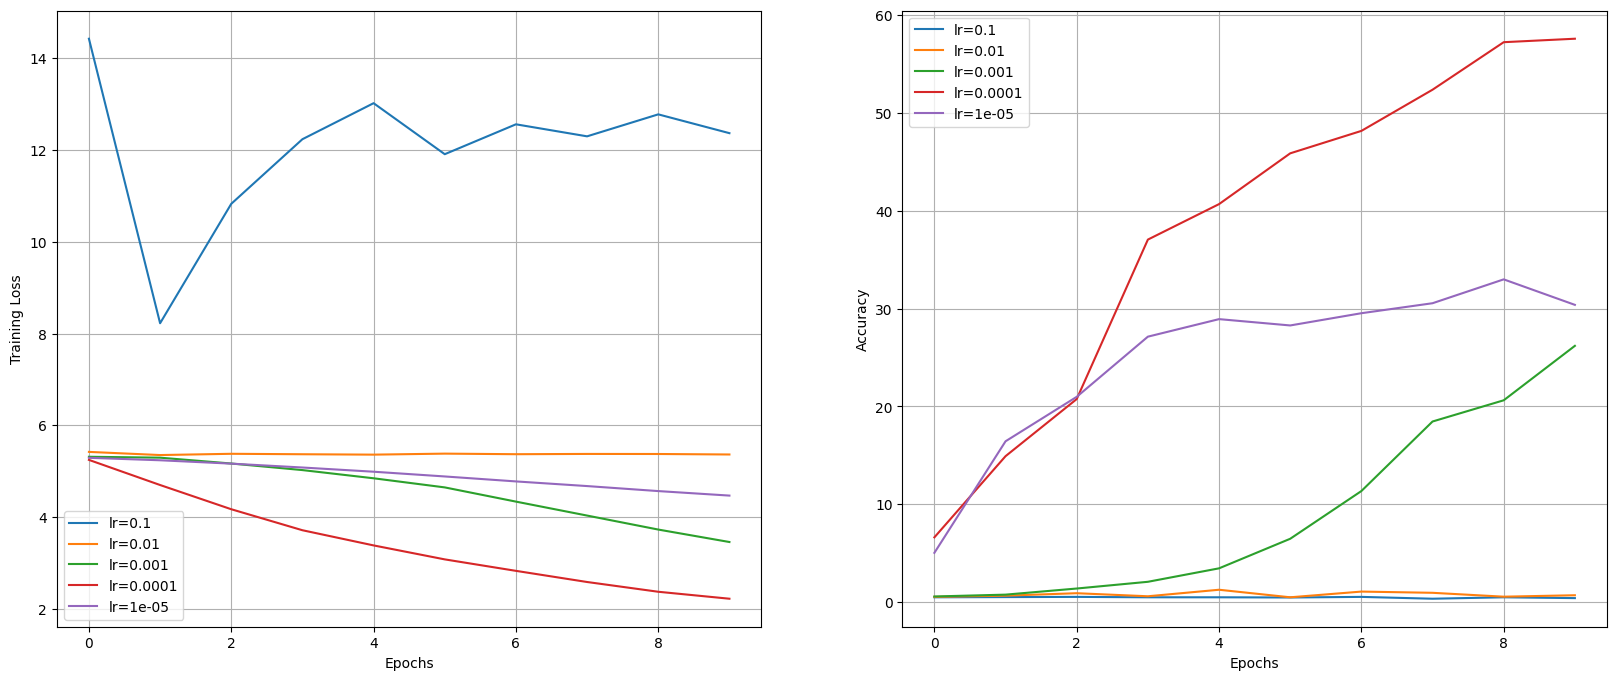

In [27]:
adam_lr_loss, adam_lr_accuracy = [], []
lr_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
for lr in lr_rates:
    print(lr)
    checkModel = copy.deepcopy(NewModel)
    checkModel.to(device)

    optimizer = optim.Adam(params=checkModel.parameters(), lr=lr, weight_decay=0.0001)

    torch.cuda.empty_cache()
    gc.collect()

    training_loss, training_accuracy = overfit_model(checkModel, TrainLoader, 
                                                        optimizer, criterion, num_epochs=10)

    adam_lr_loss.append(training_loss)
    adam_lr_accuracy.append(training_accuracy)

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
for i in range(len(lr_rates)):
    ax[0].plot(range(len(adam_lr_loss[i])), adam_lr_loss[i], label=f"lr={lr_rates[i]}")
    ax[1].plot(range(len(adam_lr_accuracy[i])), adam_lr_accuracy[i], label=f"lr={lr_rates[i]}")

for i in range(2):
    ax[i].grid()
    ax[i].set_xlabel('Epochs')
    ax[i].legend()

ax[0].set_ylabel('Training Loss')
ax[1].set_ylabel('Accuracy')
plt.show()

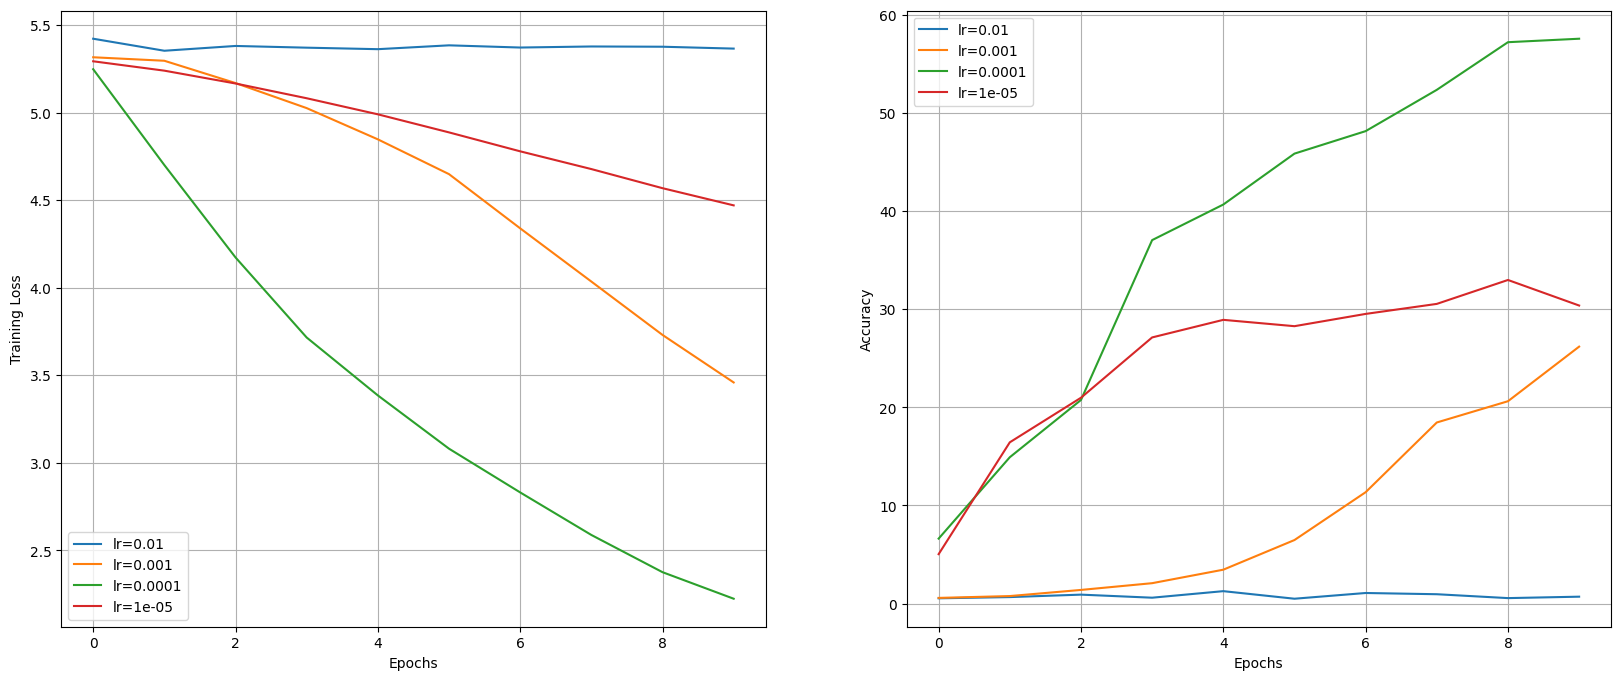

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
for i in range(1, len(lr_rates)):
    ax[0].plot(range(len(adam_lr_loss[i])), adam_lr_loss[i], label=f"lr={lr_rates[i]}")
    ax[1].plot(range(len(adam_lr_accuracy[i])), adam_lr_accuracy[i], label=f"lr={lr_rates[i]}")

for i in range(2):
    ax[i].grid()
    ax[i].set_xlabel('Epochs')
    ax[i].legend()

ax[0].set_ylabel('Training Loss')
ax[1].set_ylabel('Accuracy')
plt.show()

## Coarse grid (train for 1-5 epochs)

Choose a few values of learning rate and weight decay around what worked on step 3, tain a few models for 1-5 epochs

Good weight decay to try: 1e-4, 1e-5, 0

In [29]:
adam_lr_wd_loss, adam_lr_wd_accuracy = [], []
# lr_rates = np.random.uniform(3/4 * 1e-3, 4/3 * 1e-3, size=9)
# lr_rates = [1e-2, 1e-3, 1e-4, 1e-5]
weight_decay = np.array([0, 1e-4, 1e-5])

lr = 1e-4
for wd in weight_decay:
    print(f"lr={lr}, wd={wd}")
    checkModel = copy.deepcopy(NewModel)
    checkModel.to(device)

    optimizer = optim.Adam(params=checkModel.parameters(), lr=lr, weight_decay=wd)

    torch.cuda.empty_cache()
    gc.collect()

    training_loss, training_accuracy = overfit_model(checkModel, TrainLoader, 
                                                        optimizer, criterion, num_epochs=5)

    adam_lr_wd_loss.append(training_loss)
    adam_lr_wd_accuracy.append(training_accuracy)
    print()


lr=0.0001, wd=0.0


100%|██████████| 2400/2400 [00:33<00:00, 70.71it/s]


Epoch [1/5], Loss: 5.235321113069852


100%|██████████| 2400/2400 [00:23<00:00, 100.22it/s]


Accuracy of the network on the 2400 train images: 7.729166666666667


100%|██████████| 2400/2400 [00:34<00:00, 70.45it/s]


Epoch [2/5], Loss: 4.668548411031564


100%|██████████| 2400/2400 [00:25<00:00, 95.43it/s] 


Accuracy of the network on the 2400 train images: 17.458333333333332


100%|██████████| 2400/2400 [00:32<00:00, 72.86it/s]


Epoch [3/5], Loss: 4.106863788167636


100%|██████████| 2400/2400 [00:24<00:00, 99.74it/s] 


Accuracy of the network on the 2400 train images: 28.145833333333332


100%|██████████| 2400/2400 [00:33<00:00, 71.75it/s]


Epoch [4/5], Loss: 3.673253420839707


100%|██████████| 2400/2400 [00:23<00:00, 102.23it/s]


Accuracy of the network on the 2400 train images: 33.5


100%|██████████| 2400/2400 [00:31<00:00, 76.00it/s]


Epoch [5/5], Loss: 3.300978583569328


100%|██████████| 2400/2400 [00:24<00:00, 98.93it/s] 


Accuracy of the network on the 2400 train images: 41.083333333333336

lr=0.0001, wd=0.0001


100%|██████████| 2400/2400 [00:33<00:00, 72.09it/s]


Epoch [1/5], Loss: 5.231552566289902


100%|██████████| 2400/2400 [00:22<00:00, 105.52it/s]


Accuracy of the network on the 2400 train images: 8.208333333333334


100%|██████████| 2400/2400 [00:35<00:00, 67.65it/s]


Epoch [2/5], Loss: 4.652130766908328


100%|██████████| 2400/2400 [00:23<00:00, 102.88it/s]


Accuracy of the network on the 2400 train images: 20.729166666666668


100%|██████████| 2400/2400 [00:35<00:00, 68.38it/s]


Epoch [3/5], Loss: 4.117319660137097


100%|██████████| 2400/2400 [00:24<00:00, 99.08it/s] 


Accuracy of the network on the 2400 train images: 30.5


100%|██████████| 2400/2400 [00:35<00:00, 68.17it/s]


Epoch [4/5], Loss: 3.694625378449758


100%|██████████| 2400/2400 [00:22<00:00, 106.27it/s]


Accuracy of the network on the 2400 train images: 34.916666666666664


100%|██████████| 2400/2400 [00:34<00:00, 68.64it/s]


Epoch [5/5], Loss: 3.330385188435515


100%|██████████| 2400/2400 [00:22<00:00, 105.86it/s]


Accuracy of the network on the 2400 train images: 39.4375

lr=0.0001, wd=1e-05


100%|██████████| 2400/2400 [00:34<00:00, 69.89it/s]


Epoch [1/5], Loss: 5.238089742263158


100%|██████████| 2400/2400 [00:21<00:00, 110.51it/s]


Accuracy of the network on the 2400 train images: 6.208333333333333


100%|██████████| 2400/2400 [00:32<00:00, 74.69it/s]


Epoch [2/5], Loss: 4.6949761913220085


100%|██████████| 2400/2400 [00:21<00:00, 112.33it/s]


Accuracy of the network on the 2400 train images: 19.25


100%|██████████| 2400/2400 [00:31<00:00, 75.00it/s]


Epoch [3/5], Loss: 4.125526766727368


100%|██████████| 2400/2400 [00:21<00:00, 110.13it/s]


Accuracy of the network on the 2400 train images: 27.666666666666668


100%|██████████| 2400/2400 [00:32<00:00, 73.08it/s]


Epoch [4/5], Loss: 3.6794158998628457


100%|██████████| 2400/2400 [00:21<00:00, 109.48it/s]


Accuracy of the network on the 2400 train images: 33.875


100%|██████████| 2400/2400 [00:31<00:00, 77.17it/s]


Epoch [5/5], Loss: 3.3380944433311623


100%|██████████| 2400/2400 [00:22<00:00, 105.33it/s]

Accuracy of the network on the 2400 train images: 38.645833333333336



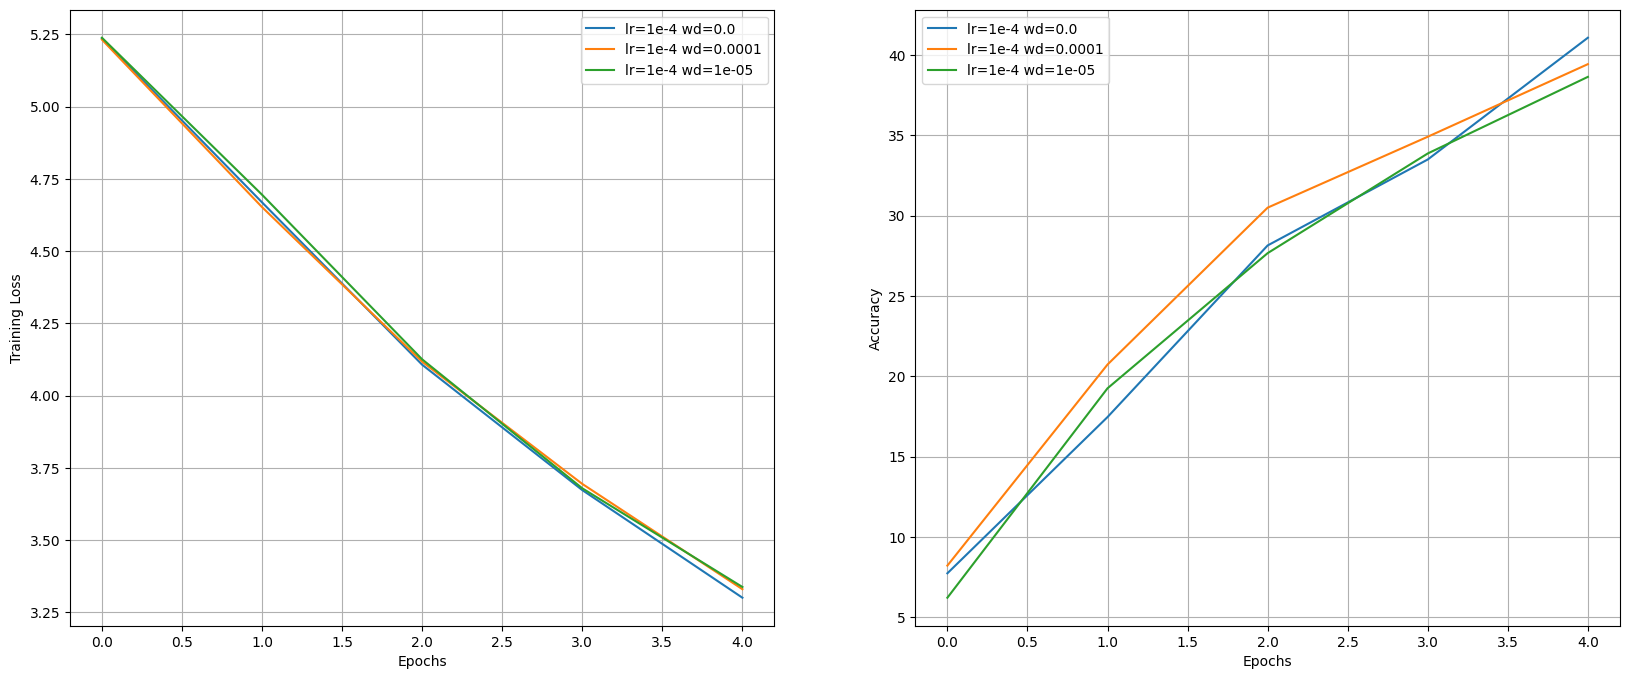

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

for j in range(len(weight_decay)):
    ax[0].plot(range(len(adam_lr_wd_loss[j])), 
                adam_lr_wd_loss[j], 
                label=f"lr=1e-4 wd={weight_decay[j]}")
    
    ax[1].plot(range(len(adam_lr_wd_accuracy[j])), 
                adam_lr_wd_accuracy[j], 
                label=f"lr=1e-4 wd={weight_decay[j]}")

for i in range(2):
    ax[i].grid()
    ax[i].set_xlabel('Epochs')
    ax[i].legend()

ax[0].set_ylabel('Training Loss')
ax[1].set_ylabel('Accuracy')
plt.show()

## Refine grid, train longer

Pick best models from coarse grid, train them for longer (~10-20 epochs) without learning decay.

Check for
- Loss curves bad initialization:
    - if there is a plateau at the initial stage of the curve.
    - if there is a plateau at the end of the curve (implying the need for learning decay).
- Train and Validation accuracy curves:
    - Overfitting
    - Underfitting

Adam is showing good result irrespective of weight decay. So, not using weight decay.

# Training
There is a small error while printing loss. I printed final batch's loss after an epoch instead of whole batches' loss.

100%|██████████| 2400/2400 [00:36<00:00, 64.96it/s]


Epoch [1/50], Loss: 5.2413457896312075


100%|██████████| 2400/2400 [00:26<00:00, 91.43it/s] 


Accuracy of the network on the 2400 train images: 7.875


100%|██████████| 597/597 [00:12<00:00, 49.54it/s] 


Accuracy of the network on the 597 validation images: 6.532663316582915


100%|██████████| 2400/2400 [00:34<00:00, 69.88it/s] 


Epoch [2/50], Loss: 4.68186437378327


100%|██████████| 2400/2400 [00:25<00:00, 92.73it/s] 


Accuracy of the network on the 2400 train images: 19.666666666666668


100%|██████████| 597/597 [00:08<00:00, 70.83it/s] 


Accuracy of the network on the 597 validation images: 15.494137353433835


100%|██████████| 2400/2400 [00:30<00:00, 79.64it/s]


Epoch [3/50], Loss: 4.113560206492742


100%|██████████| 2400/2400 [00:25<00:00, 95.04it/s] 


Accuracy of the network on the 2400 train images: 28.3125


100%|██████████| 597/597 [00:08<00:00, 69.34it/s] 


Accuracy of the network on the 597 validation images: 21.105527638190956


100%|██████████| 2400/2400 [00:33<00:00, 70.92it/s]


Epoch [4/50], Loss: 3.688069089775284


100%|██████████| 2400/2400 [00:23<00:00, 103.60it/s]


Accuracy of the network on the 2400 train images: 36.833333333333336


100%|██████████| 597/597 [00:08<00:00, 73.78it/s] 


Accuracy of the network on the 597 validation images: 27.30318257956449


100%|██████████| 2400/2400 [00:33<00:00, 71.65it/s]


Epoch [5/50], Loss: 3.319660108288129


100%|██████████| 2400/2400 [00:26<00:00, 91.18it/s] 


Accuracy of the network on the 2400 train images: 44.9375


100%|██████████| 597/597 [00:08<00:00, 73.73it/s] 


Accuracy of the network on the 597 validation images: 32.74706867671692


100%|██████████| 2400/2400 [00:34<00:00, 70.25it/s]


Epoch [6/50], Loss: 2.992416353051861


100%|██████████| 2400/2400 [00:25<00:00, 95.46it/s] 


Accuracy of the network on the 2400 train images: 48.375


100%|██████████| 597/597 [00:09<00:00, 64.90it/s] 


Accuracy of the network on the 597 validation images: 35.00837520938023


100%|██████████| 2400/2400 [00:36<00:00, 65.90it/s]


Epoch [7/50], Loss: 2.7253596523124726


100%|██████████| 2400/2400 [00:29<00:00, 80.80it/s]


Accuracy of the network on the 2400 train images: 51.708333333333336


100%|██████████| 597/597 [00:09<00:00, 64.28it/s] 


Accuracy of the network on the 597 validation images: 38.777219430485765


100%|██████████| 2400/2400 [00:36<00:00, 66.64it/s]


Epoch [8/50], Loss: 2.484351253087322


100%|██████████| 2400/2400 [00:25<00:00, 95.29it/s] 


Accuracy of the network on the 2400 train images: 53.333333333333336


100%|██████████| 597/597 [00:08<00:00, 69.33it/s] 


Accuracy of the network on the 597 validation images: 36.93467336683417


100%|██████████| 2400/2400 [00:35<00:00, 68.09it/s]


Epoch [9/50], Loss: 2.2864166498122116


100%|██████████| 2400/2400 [00:26<00:00, 91.13it/s] 


Accuracy of the network on the 2400 train images: 56.354166666666664


100%|██████████| 597/597 [00:08<00:00, 70.07it/s] 


Accuracy of the network on the 597 validation images: 39.949748743718594


100%|██████████| 2400/2400 [00:35<00:00, 68.06it/s]


Epoch [10/50], Loss: 2.1060569876401374


100%|██████████| 2400/2400 [00:26<00:00, 91.51it/s] 


Accuracy of the network on the 2400 train images: 58.25


100%|██████████| 597/597 [00:08<00:00, 70.52it/s] 


Accuracy of the network on the 597 validation images: 43.21608040201005


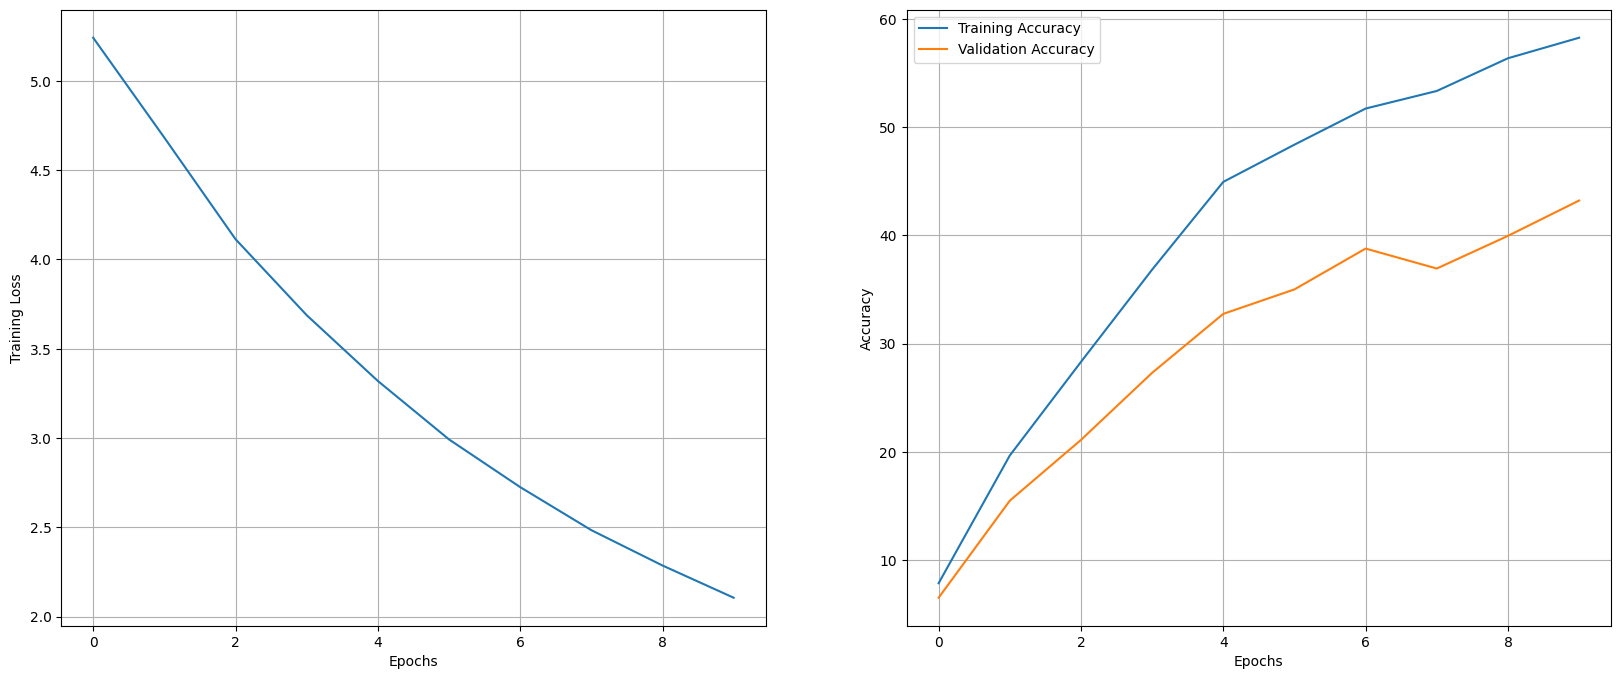

100%|██████████| 2400/2400 [00:35<00:00, 66.70it/s]


Epoch [11/50], Loss: 1.9601989564780766


100%|██████████| 2400/2400 [00:26<00:00, 90.07it/s] 


Accuracy of the network on the 2400 train images: 61.041666666666664


100%|██████████| 597/597 [00:07<00:00, 76.44it/s] 


Accuracy of the network on the 597 validation images: 44.221105527638194


100%|██████████| 2400/2400 [00:32<00:00, 73.27it/s]


Epoch [12/50], Loss: 1.7980317744271208


100%|██████████| 2400/2400 [00:24<00:00, 97.01it/s] 


Accuracy of the network on the 2400 train images: 65.47916666666667


100%|██████████| 597/597 [00:08<00:00, 67.14it/s] 


Accuracy of the network on the 597 validation images: 47.654941373534335


100%|██████████| 2400/2400 [00:35<00:00, 68.51it/s]


Epoch [13/50], Loss: 1.6805259058764204


100%|██████████| 2400/2400 [00:25<00:00, 93.16it/s] 


Accuracy of the network on the 2400 train images: 67.1875


100%|██████████| 597/597 [00:07<00:00, 76.10it/s] 


Accuracy of the network on the 597 validation images: 45.7286432160804


100%|██████████| 2400/2400 [00:35<00:00, 67.66it/s]


Epoch [14/50], Loss: 1.571168994908997


100%|██████████| 2400/2400 [00:25<00:00, 94.27it/s] 


Accuracy of the network on the 2400 train images: 67.25


100%|██████████| 597/597 [00:08<00:00, 71.87it/s] 


Accuracy of the network on the 597 validation images: 46.231155778894475


100%|██████████| 2400/2400 [00:34<00:00, 68.61it/s]


Epoch [15/50], Loss: 1.4596512578427792


100%|██████████| 2400/2400 [00:26<00:00, 91.36it/s] 


Accuracy of the network on the 2400 train images: 69.29166666666667


100%|██████████| 597/597 [00:08<00:00, 71.78it/s] 


Accuracy of the network on the 597 validation images: 46.984924623115575


100%|██████████| 2400/2400 [00:34<00:00, 68.95it/s]


Epoch [16/50], Loss: 1.3351087799458765


100%|██████████| 2400/2400 [00:25<00:00, 93.54it/s] 


Accuracy of the network on the 2400 train images: 72.35416666666667


100%|██████████| 597/597 [00:08<00:00, 69.25it/s] 


Accuracy of the network on the 597 validation images: 49.49748743718593


100%|██████████| 2400/2400 [00:35<00:00, 67.04it/s]


Epoch [17/50], Loss: 1.2640883927113222


100%|██████████| 2400/2400 [00:27<00:00, 87.68it/s] 


Accuracy of the network on the 2400 train images: 69.16666666666667


100%|██████████| 597/597 [00:08<00:00, 67.48it/s] 


Accuracy of the network on the 597 validation images: 47.403685092127304


100%|██████████| 2400/2400 [00:35<00:00, 66.77it/s]


Epoch [18/50], Loss: 1.1982450336955177


100%|██████████| 2400/2400 [00:25<00:00, 93.28it/s] 


Accuracy of the network on the 2400 train images: 71.97916666666667


100%|██████████| 597/597 [00:08<00:00, 72.03it/s] 


Accuracy of the network on the 597 validation images: 48.324958123953095


100%|██████████| 2400/2400 [00:34<00:00, 68.58it/s]


Epoch [19/50], Loss: 1.1096244658944974


100%|██████████| 2400/2400 [00:25<00:00, 94.07it/s] 


Accuracy of the network on the 2400 train images: 74.41666666666667


100%|██████████| 597/597 [00:08<00:00, 71.87it/s] 


Accuracy of the network on the 597 validation images: 48.82747068676717


100%|██████████| 2400/2400 [00:34<00:00, 69.71it/s]


Epoch [20/50], Loss: 1.0463913111149061


100%|██████████| 2400/2400 [00:25<00:00, 93.97it/s] 


Accuracy of the network on the 2400 train images: 76.8125


100%|██████████| 597/597 [00:08<00:00, 71.07it/s] 


Accuracy of the network on the 597 validation images: 51.08877721943048


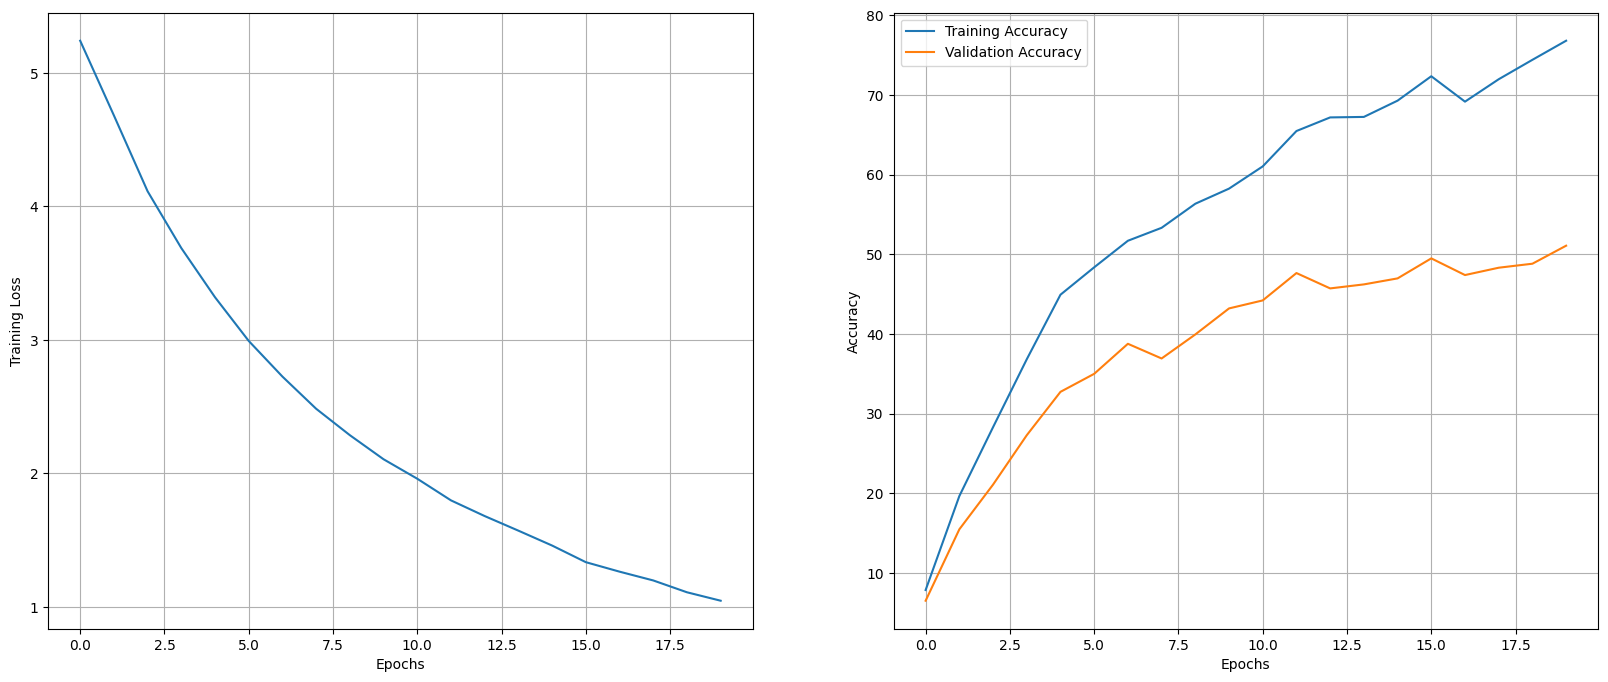

100%|██████████| 2400/2400 [00:35<00:00, 68.23it/s]


Epoch [21/50], Loss: 0.9560065706861981


100%|██████████| 2400/2400 [00:25<00:00, 93.47it/s] 


Accuracy of the network on the 2400 train images: 74.41666666666667


100%|██████████| 597/597 [00:08<00:00, 67.54it/s] 


Accuracy of the network on the 597 validation images: 46.39865996649916


100%|██████████| 2400/2400 [00:34<00:00, 70.53it/s]


Epoch [22/50], Loss: 0.9017335945447363


100%|██████████| 2400/2400 [00:25<00:00, 94.65it/s] 


Accuracy of the network on the 2400 train images: 78.875


100%|██████████| 597/597 [00:08<00:00, 71.68it/s] 


Accuracy of the network on the 597 validation images: 51.675041876046905


100%|██████████| 2400/2400 [00:34<00:00, 69.83it/s]


Epoch [23/50], Loss: 0.8379920482022377


100%|██████████| 2400/2400 [00:26<00:00, 90.69it/s] 


Accuracy of the network on the 2400 train images: 78.375


100%|██████████| 597/597 [00:08<00:00, 70.51it/s] 


Accuracy of the network on the 597 validation images: 49.49748743718593


100%|██████████| 2400/2400 [00:33<00:00, 70.61it/s]


Epoch [24/50], Loss: 0.811220326426798


100%|██████████| 2400/2400 [00:26<00:00, 89.30it/s] 


Accuracy of the network on the 2400 train images: 79.72916666666667


100%|██████████| 597/597 [00:08<00:00, 70.77it/s] 


Accuracy of the network on the 597 validation images: 50.753768844221106


100%|██████████| 2400/2400 [00:34<00:00, 68.96it/s]


Epoch [25/50], Loss: 0.7492265229177428


100%|██████████| 2400/2400 [00:25<00:00, 92.89it/s] 


Accuracy of the network on the 2400 train images: 78.72916666666667


100%|██████████| 597/597 [00:08<00:00, 69.72it/s] 


Accuracy of the network on the 597 validation images: 48.91122278056952


100%|██████████| 2400/2400 [00:34<00:00, 69.45it/s]


Epoch [26/50], Loss: 0.7231548581053358


100%|██████████| 2400/2400 [00:25<00:00, 92.87it/s] 


Accuracy of the network on the 2400 train images: 73.125


100%|██████████| 597/597 [00:08<00:00, 70.47it/s] 


Accuracy of the network on the 597 validation images: 44.891122278056955


100%|██████████| 2400/2400 [00:34<00:00, 68.91it/s]


Epoch [27/50], Loss: 0.6849565741943177


100%|██████████| 2400/2400 [00:25<00:00, 94.64it/s] 


Accuracy of the network on the 2400 train images: 81.58333333333333


100%|██████████| 597/597 [00:08<00:00, 68.82it/s] 


Accuracy of the network on the 597 validation images: 52.428810720268004


100%|██████████| 2400/2400 [00:36<00:00, 65.57it/s]


Epoch [28/50], Loss: 0.6369491506443592


100%|██████████| 2400/2400 [00:27<00:00, 88.27it/s] 


Accuracy of the network on the 2400 train images: 75.83333333333333


100%|██████████| 597/597 [00:08<00:00, 68.37it/s] 


Accuracy of the network on the 597 validation images: 45.22613065326633


100%|██████████| 2400/2400 [00:36<00:00, 65.66it/s]


Epoch [29/50], Loss: 0.623725041160554


100%|██████████| 2400/2400 [00:26<00:00, 90.69it/s] 


Accuracy of the network on the 2400 train images: 79.35416666666667


100%|██████████| 597/597 [00:08<00:00, 69.50it/s] 


Accuracy of the network on the 597 validation images: 49.246231155778894


100%|██████████| 2400/2400 [00:35<00:00, 68.22it/s]


Epoch [30/50], Loss: 0.5801589067314853


100%|██████████| 2400/2400 [00:26<00:00, 89.94it/s] 


Accuracy of the network on the 2400 train images: 81.70833333333333


100%|██████████| 597/597 [00:08<00:00, 68.36it/s] 


Accuracy of the network on the 597 validation images: 51.34003350083752


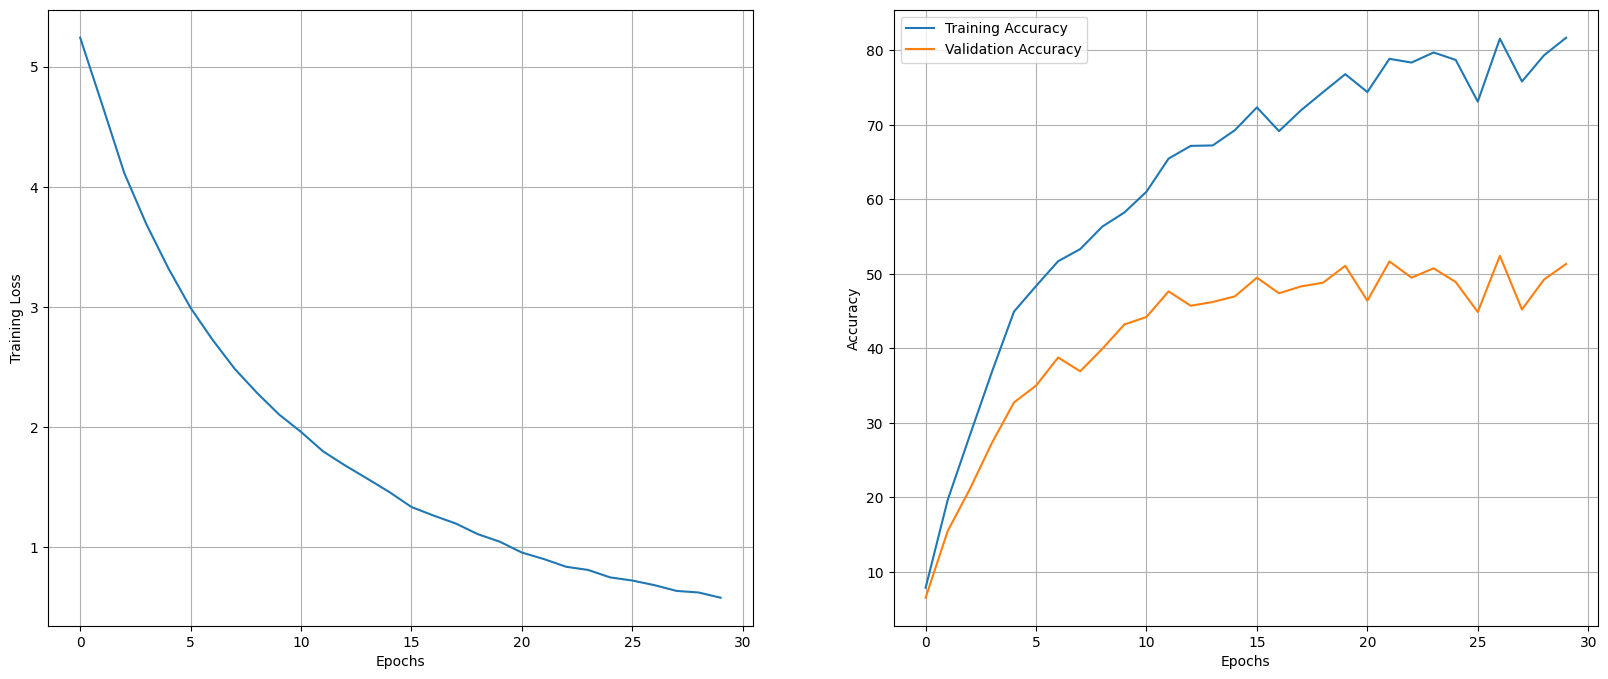

100%|██████████| 2400/2400 [00:36<00:00, 65.77it/s]


Epoch [31/50], Loss: 0.5427152598460331


100%|██████████| 2400/2400 [00:24<00:00, 99.24it/s] 


Accuracy of the network on the 2400 train images: 82.45833333333333


100%|██████████| 597/597 [00:07<00:00, 74.71it/s] 


Accuracy of the network on the 597 validation images: 51.675041876046905


100%|██████████| 2400/2400 [00:35<00:00, 68.16it/s]


Epoch [32/50], Loss: 0.5196392464755869


100%|██████████| 2400/2400 [00:27<00:00, 87.71it/s] 


Accuracy of the network on the 2400 train images: 75.25


100%|██████████| 597/597 [00:08<00:00, 67.89it/s] 


Accuracy of the network on the 597 validation images: 46.39865996649916


100%|██████████| 2400/2400 [00:35<00:00, 67.91it/s]


Epoch [33/50], Loss: 0.48232519781476263


100%|██████████| 2400/2400 [00:24<00:00, 97.98it/s] 


Accuracy of the network on the 2400 train images: 75.75


100%|██████████| 597/597 [00:08<00:00, 68.93it/s] 


Accuracy of the network on the 597 validation images: 45.97989949748744


100%|██████████| 2400/2400 [00:35<00:00, 67.17it/s]


Epoch [34/50], Loss: 0.4780910125525891


100%|██████████| 2400/2400 [00:26<00:00, 91.20it/s] 


Accuracy of the network on the 2400 train images: 80.0


100%|██████████| 597/597 [00:08<00:00, 70.90it/s] 


Accuracy of the network on the 597 validation images: 46.901172529313236


100%|██████████| 2400/2400 [00:35<00:00, 68.43it/s]


Epoch [35/50], Loss: 0.43461708112131114


100%|██████████| 2400/2400 [00:26<00:00, 91.94it/s] 


Accuracy of the network on the 2400 train images: 80.47916666666667


100%|██████████| 597/597 [00:08<00:00, 67.88it/s] 


Accuracy of the network on the 597 validation images: 48.40871021775544


100%|██████████| 2400/2400 [00:35<00:00, 68.43it/s]


Epoch [36/50], Loss: 0.41027431090619454


100%|██████████| 2400/2400 [00:26<00:00, 89.97it/s] 


Accuracy of the network on the 2400 train images: 83.16666666666667


100%|██████████| 597/597 [00:08<00:00, 70.26it/s] 


Accuracy of the network on the 597 validation images: 47.48743718592965


100%|██████████| 2400/2400 [00:36<00:00, 66.20it/s]


Epoch [37/50], Loss: 0.3897738703432818


100%|██████████| 2400/2400 [00:26<00:00, 91.09it/s] 


Accuracy of the network on the 2400 train images: 80.72916666666667


100%|██████████| 597/597 [00:08<00:00, 72.54it/s] 


Accuracy of the network on the 597 validation images: 48.40871021775544


100%|██████████| 2400/2400 [00:35<00:00, 66.96it/s]


Epoch [38/50], Loss: 0.3929294184735166


100%|██████████| 2400/2400 [00:26<00:00, 89.70it/s] 


Accuracy of the network on the 2400 train images: 82.625


100%|██████████| 597/597 [00:08<00:00, 68.80it/s] 


Accuracy of the network on the 597 validation images: 49.32998324958124


100%|██████████| 2400/2400 [00:35<00:00, 67.79it/s]


Epoch [39/50], Loss: 0.3675144817997292


100%|██████████| 2400/2400 [00:26<00:00, 90.55it/s] 


Accuracy of the network on the 2400 train images: 85.1875


100%|██████████| 597/597 [00:08<00:00, 70.45it/s] 


Accuracy of the network on the 597 validation images: 50.335008375209384


100%|██████████| 2400/2400 [00:34<00:00, 69.28it/s]


Epoch [40/50], Loss: 0.35482485700517524


100%|██████████| 2400/2400 [00:25<00:00, 94.18it/s] 


Accuracy of the network on the 2400 train images: 84.3125


100%|██████████| 597/597 [00:08<00:00, 69.75it/s] 

Accuracy of the network on the 597 validation images: 50.50251256281407


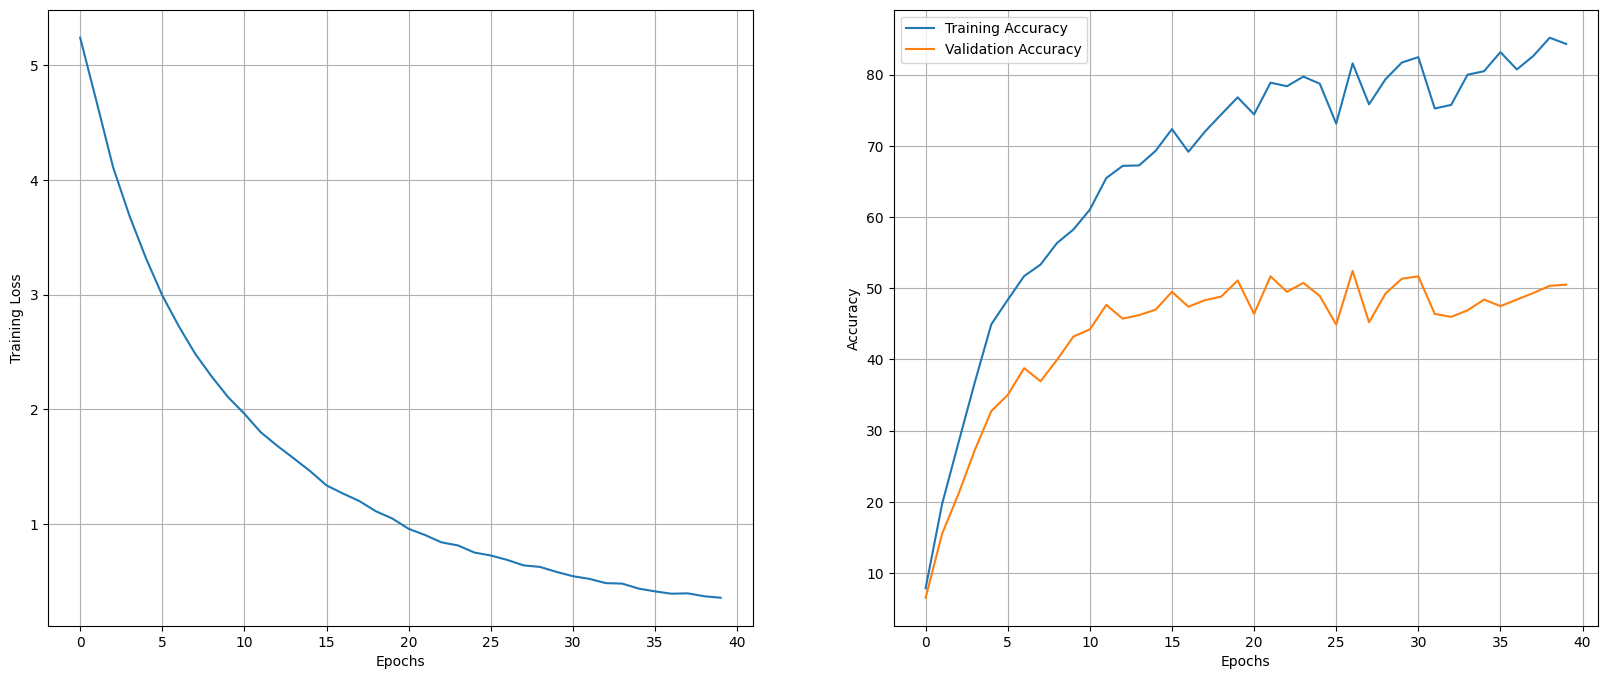

100%|██████████| 2400/2400 [00:34<00:00, 68.82it/s]


Epoch [41/50], Loss: 0.34319020639205744


100%|██████████| 2400/2400 [00:25<00:00, 94.58it/s] 


Accuracy of the network on the 2400 train images: 82.89583333333333


100%|██████████| 597/597 [00:07<00:00, 76.54it/s] 


Accuracy of the network on the 597 validation images: 49.83249581239531


100%|██████████| 2400/2400 [00:34<00:00, 69.99it/s]


Epoch [42/50], Loss: 0.3390125053629223


100%|██████████| 2400/2400 [00:25<00:00, 94.93it/s] 


Accuracy of the network on the 2400 train images: 85.5


100%|██████████| 597/597 [00:08<00:00, 71.68it/s] 


Accuracy of the network on the 597 validation images: 49.74874371859296


100%|██████████| 2400/2400 [00:34<00:00, 69.77it/s]


Epoch [43/50], Loss: 0.3254421753993059


100%|██████████| 2400/2400 [00:26<00:00, 91.19it/s] 


Accuracy of the network on the 2400 train images: 82.52083333333333


100%|██████████| 597/597 [00:08<00:00, 72.52it/s] 


Accuracy of the network on the 597 validation images: 48.91122278056952


100%|██████████| 2400/2400 [00:35<00:00, 68.39it/s]


Epoch [44/50], Loss: 0.29160422073543185


100%|██████████| 2400/2400 [00:25<00:00, 93.94it/s] 


Accuracy of the network on the 2400 train images: 83.0


100%|██████████| 597/597 [00:08<00:00, 71.56it/s] 


Accuracy of the network on the 597 validation images: 48.65996649916248


100%|██████████| 2400/2400 [00:33<00:00, 70.78it/s]


Epoch [45/50], Loss: 0.28702436009359494


100%|██████████| 2400/2400 [00:25<00:00, 93.97it/s] 


Accuracy of the network on the 2400 train images: 83.3125


100%|██████████| 597/597 [00:07<00:00, 76.78it/s] 


Accuracy of the network on the 597 validation images: 48.40871021775544


100%|██████████| 2400/2400 [00:34<00:00, 69.76it/s]


Epoch [46/50], Loss: 0.28692900656835263


100%|██████████| 2400/2400 [00:25<00:00, 93.15it/s] 


Accuracy of the network on the 2400 train images: 82.72916666666667


100%|██████████| 597/597 [00:08<00:00, 72.63it/s] 


Accuracy of the network on the 597 validation images: 47.15242881072027


100%|██████████| 2400/2400 [00:34<00:00, 69.88it/s]


Epoch [47/50], Loss: 0.27582262199203494


100%|██████████| 2400/2400 [00:26<00:00, 91.62it/s] 


Accuracy of the network on the 2400 train images: 81.54166666666667


100%|██████████| 597/597 [00:07<00:00, 75.15it/s] 


Accuracy of the network on the 597 validation images: 45.97989949748744


100%|██████████| 2400/2400 [00:35<00:00, 68.45it/s]


Epoch [48/50], Loss: 0.262886816292142


100%|██████████| 2400/2400 [00:25<00:00, 93.48it/s] 


Accuracy of the network on the 2400 train images: 84.72916666666667


100%|██████████| 597/597 [00:08<00:00, 71.46it/s] 


Accuracy of the network on the 597 validation images: 50.41876046901172


100%|██████████| 2400/2400 [00:34<00:00, 70.05it/s]


Epoch [49/50], Loss: 0.257035257883972


100%|██████████| 2400/2400 [00:25<00:00, 93.78it/s] 


Accuracy of the network on the 2400 train images: 84.625


100%|██████████| 597/597 [00:08<00:00, 72.94it/s] 


Accuracy of the network on the 597 validation images: 48.073701842546065


100%|██████████| 2400/2400 [00:59<00:00, 40.42it/s]


Epoch [50/50], Loss: 0.24746144926683125


100%|██████████| 2400/2400 [00:42<00:00, 55.88it/s]


Accuracy of the network on the 2400 train images: 87.29166666666667


100%|██████████| 597/597 [00:14<00:00, 42.00it/s]


Accuracy of the network on the 597 validation images: 51.005025125628144


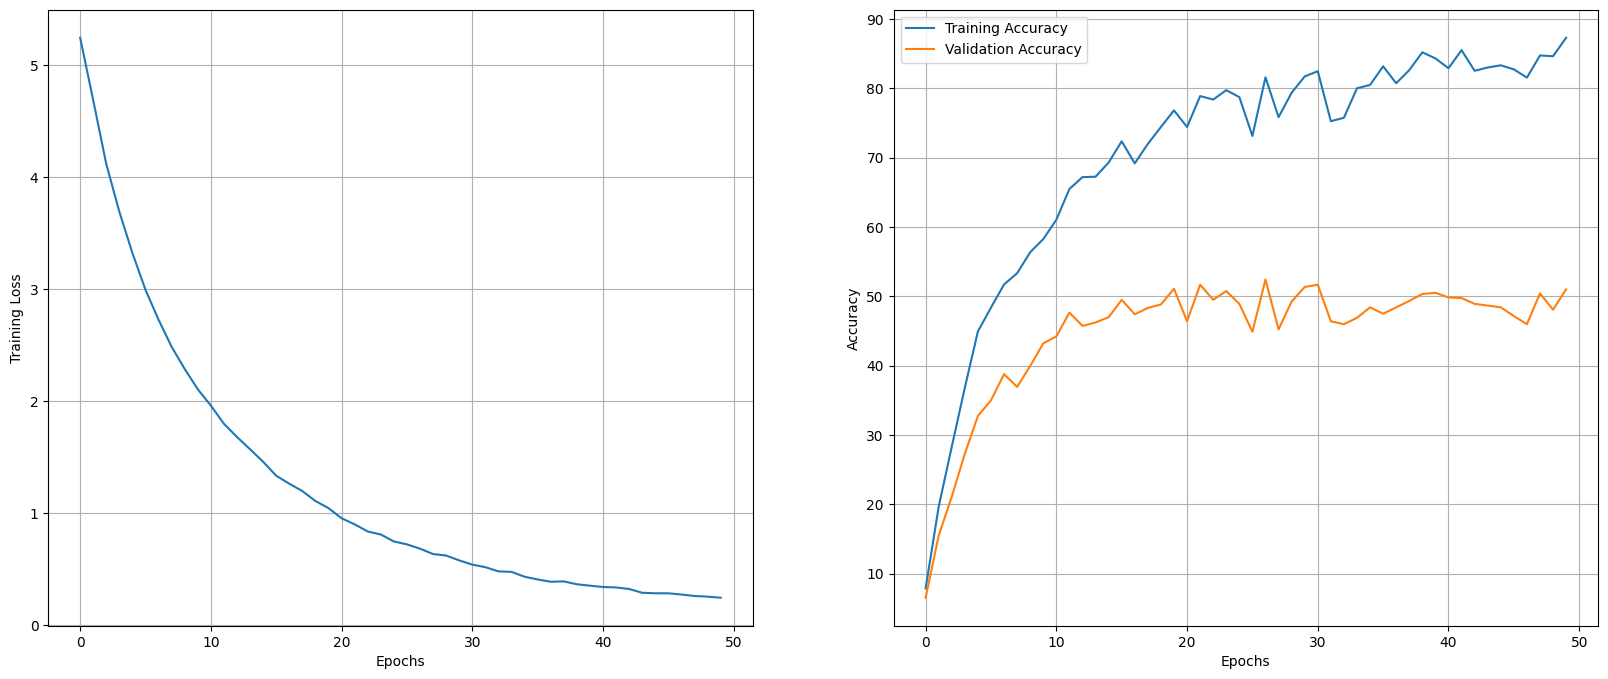

100%|██████████| 2897/2897 [01:12<00:00, 39.89it/s]

Accuracy of the network on the 2897 test images: 50.91473938557128


50.91473938557128

In [31]:
checkModel = copy.deepcopy(NewModel)
checkModel.to(device)

torch.cuda.empty_cache()
gc.collect()

training_accuracy = []
training_loss = []
validation_accuracy = []

# Number of epochs
num_epochs = 50

optimizer = optim.Adam(params=checkModel.parameters(), lr=1e-4, weight_decay=0)

for epoch in range(num_epochs):
    checkModel.train()

    running_loss = 0    
    for input_data, labels in tqdm.tqdm(TrainLoader, total=len(TrainLoader)):
        # Forward pass
        labels, input_data = labels.to(device), input_data.to(device)
        output = checkModel(input_data)
        
        # Compute loss
        loss = criterion(output, labels.long())
        running_loss += loss.item()
        # Backward pass
        optimizer.zero_grad()  # Zero the gradients
        loss.backward()  # Compute gradients
        optimizer.step()  # Update weights
    # scheduler.step(running_loss)  # Update learning rate
        
    # Print training progress
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(TrainLoader)}')
    training_loss.append(running_loss / len(TrainLoader))

    training_accuracy.append(calculate_accuracy(checkModel, TrainLoader, data_type='train'))
    validation_accuracy.append(calculate_accuracy(checkModel, ValidationLoader, data_type='validation'))
    

    if (epoch + 1) % 10 == 0:
        fig, ax = plt.subplots(1, 2, figsize=(20, 8))
        ax[0].plot(range(len(training_loss)), training_loss)
        ax[1].plot(range(len(training_accuracy)), training_accuracy, label='Training Accuracy')
        ax[1].plot(range(len(validation_accuracy)), validation_accuracy, label='Validation Accuracy')
        ax[1].grid()
        ax[0].grid()
        ax[0].set_xlabel('Epochs')
        ax[0].set_ylabel('Training Loss')
        ax[1].set_xlabel('Epochs')
        ax[1].set_ylabel('Accuracy')
        ax[1].legend()
        plt.show()
        torch.save(checkModel.state_dict(), f"2048_checkModel_{epoch}.pth")
calculate_accuracy(checkModel, TestLoader, data_type='test')

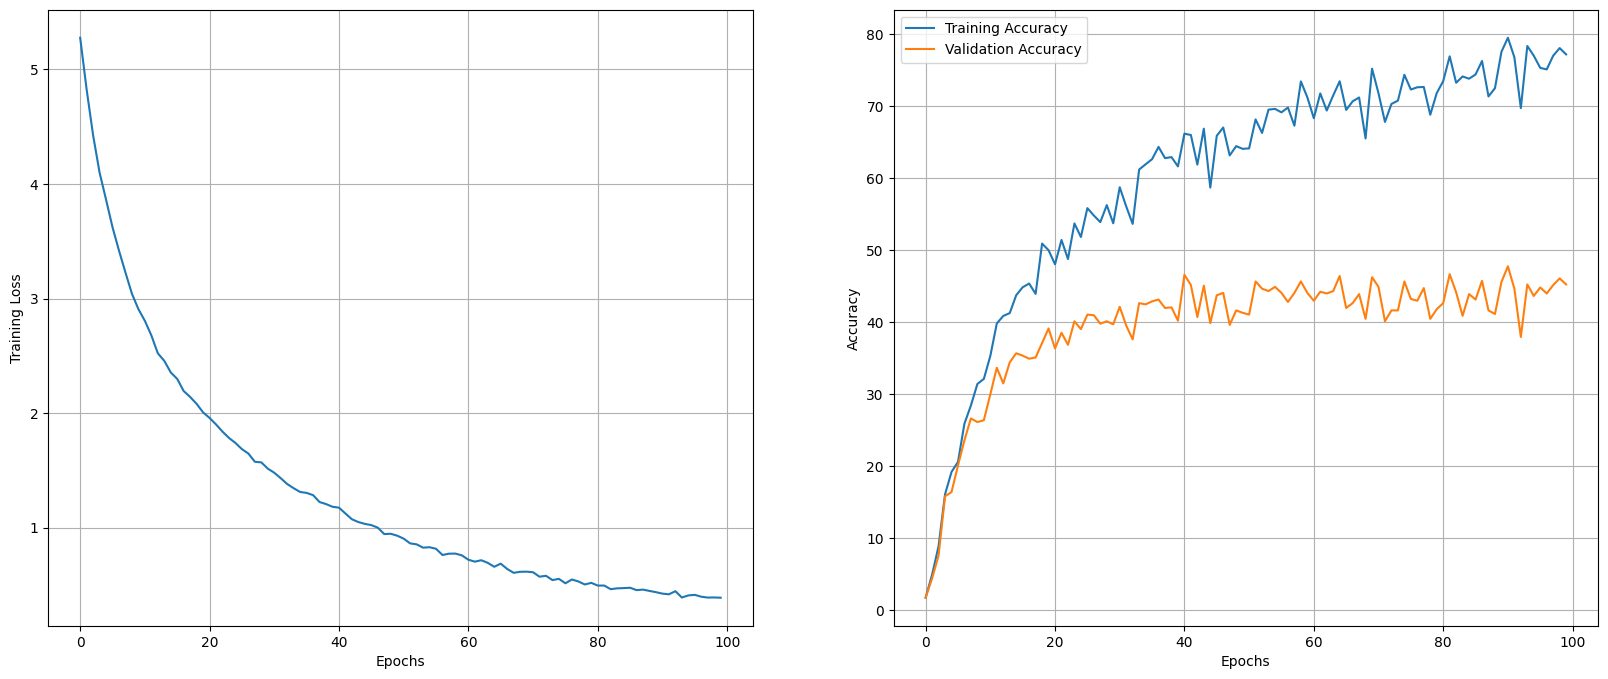

In [70]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].plot(range(len(training_loss)), training_loss)
ax[1].plot(range(len(training_accuracy)), training_accuracy, label='Training Accuracy')
ax[1].plot(range(len(validation_accuracy)), validation_accuracy, label='Validation Accuracy')
ax[1].grid()
ax[0].grid()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.show()

100%|██████████| 2400/2400 [01:21<00:00, 29.56it/s]


Epoch [51/100], Loss: 0.5383704813404347


100%|██████████| 2400/2400 [00:24<00:00, 99.22it/s] 


Accuracy of the network on the 2400 train images: 82.0


100%|██████████| 597/597 [00:08<00:00, 68.10it/s] 


Accuracy of the network on the 597 validation images: 52.09380234505863


100%|██████████| 2400/2400 [01:15<00:00, 31.66it/s]


Epoch [52/100], Loss: 0.32302883242819536


100%|██████████| 2400/2400 [00:22<00:00, 108.84it/s]


Accuracy of the network on the 2400 train images: 80.14583333333333


100%|██████████| 597/597 [00:07<00:00, 79.35it/s] 


Accuracy of the network on the 597 validation images: 51.17252931323283


100%|██████████| 2400/2400 [01:17<00:00, 31.01it/s]


Epoch [53/100], Loss: 0.269349552126439


100%|██████████| 2400/2400 [00:25<00:00, 94.64it/s] 


Accuracy of the network on the 2400 train images: 81.70833333333333


100%|██████████| 597/597 [00:10<00:00, 55.42it/s] 


Accuracy of the network on the 597 validation images: 50.50251256281407


100%|██████████| 2400/2400 [01:32<00:00, 26.00it/s]


Epoch [54/100], Loss: 0.23891991896377002


100%|██████████| 2400/2400 [00:22<00:00, 108.28it/s]


Accuracy of the network on the 2400 train images: 79.22916666666667


100%|██████████| 597/597 [00:07<00:00, 81.49it/s] 


Accuracy of the network on the 597 validation images: 49.32998324958124


100%|██████████| 2400/2400 [01:14<00:00, 32.18it/s]


Epoch [55/100], Loss: 0.17717863697945527


100%|██████████| 2400/2400 [00:21<00:00, 109.31it/s]


Accuracy of the network on the 2400 train images: 81.52083333333333


100%|██████████| 597/597 [00:07<00:00, 76.16it/s] 


Accuracy of the network on the 597 validation images: 53.18257956448911


100%|██████████| 2400/2400 [01:14<00:00, 32.06it/s]


Epoch [56/100], Loss: 0.15015528674336653


100%|██████████| 2400/2400 [00:22<00:00, 108.70it/s]


Accuracy of the network on the 2400 train images: 93.10416666666667


100%|██████████| 597/597 [00:07<00:00, 82.46it/s] 


Accuracy of the network on the 597 validation images: 61.80904522613066


100%|██████████| 2400/2400 [01:14<00:00, 32.08it/s]


Epoch [57/100], Loss: 0.1352690908589095


100%|██████████| 2400/2400 [00:22<00:00, 108.18it/s]


Accuracy of the network on the 2400 train images: 93.95833333333333


100%|██████████| 597/597 [00:07<00:00, 81.99it/s] 


Accuracy of the network on the 597 validation images: 59.04522613065327


100%|██████████| 2400/2400 [01:15<00:00, 31.75it/s]


Epoch [58/100], Loss: 0.13006451954183174


100%|██████████| 2400/2400 [00:26<00:00, 91.27it/s] 


Accuracy of the network on the 2400 train images: 93.02083333333333


100%|██████████| 597/597 [00:07<00:00, 82.83it/s] 


Accuracy of the network on the 597 validation images: 57.70519262981575


100%|██████████| 2400/2400 [01:15<00:00, 31.92it/s]


Epoch [59/100], Loss: 0.11278924624205089


100%|██████████| 2400/2400 [00:22<00:00, 108.85it/s]


Accuracy of the network on the 2400 train images: 88.70833333333333


100%|██████████| 597/597 [00:07<00:00, 82.24it/s] 


Accuracy of the network on the 597 validation images: 57.370184254606365


100%|██████████| 2400/2400 [01:15<00:00, 32.00it/s]


Epoch [60/100], Loss: 0.10203984089287212


100%|██████████| 2400/2400 [00:22<00:00, 108.30it/s]


Accuracy of the network on the 2400 train images: 91.95833333333333


100%|██████████| 597/597 [00:07<00:00, 82.28it/s] 

Accuracy of the network on the 597 validation images: 60.050251256281406


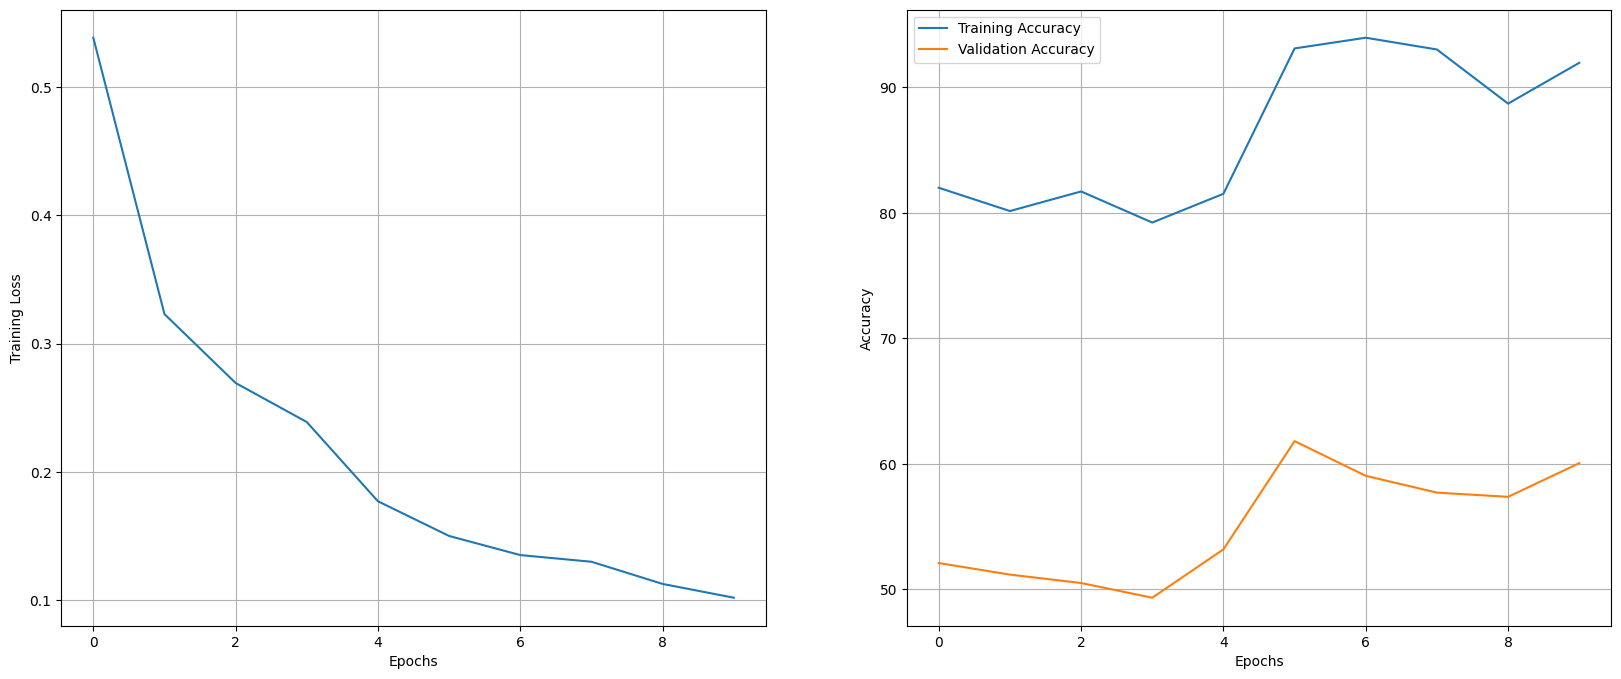

100%|██████████| 2400/2400 [01:16<00:00, 31.50it/s]


Epoch [61/100], Loss: 0.08930699009126823


100%|██████████| 2400/2400 [00:27<00:00, 87.42it/s] 


Accuracy of the network on the 2400 train images: 94.85416666666667


100%|██████████| 597/597 [00:07<00:00, 81.23it/s] 


Accuracy of the network on the 597 validation images: 61.641541038525965


100%|██████████| 2400/2400 [01:14<00:00, 32.03it/s]


Epoch [62/100], Loss: 0.08954240172688993


100%|██████████| 2400/2400 [00:22<00:00, 108.84it/s]


Accuracy of the network on the 2400 train images: 93.91666666666667


100%|██████████| 597/597 [00:07<00:00, 83.14it/s] 


Accuracy of the network on the 597 validation images: 61.892797319932995


100%|██████████| 2400/2400 [01:35<00:00, 25.19it/s]


Epoch [63/100], Loss: 0.08202584470059056


100%|██████████| 2400/2400 [00:22<00:00, 105.10it/s]


Accuracy of the network on the 2400 train images: 94.27083333333333


100%|██████████| 597/597 [00:07<00:00, 79.84it/s] 


Accuracy of the network on the 597 validation images: 60.469011725293136


100%|██████████| 2400/2400 [01:21<00:00, 29.61it/s]


Epoch [64/100], Loss: 0.08168117169857245


100%|██████████| 2400/2400 [00:23<00:00, 101.60it/s]


Accuracy of the network on the 2400 train images: 94.79166666666667


100%|██████████| 597/597 [00:07<00:00, 81.95it/s] 


Accuracy of the network on the 597 validation images: 61.72529313232831


100%|██████████| 2400/2400 [01:38<00:00, 24.42it/s]


Epoch [65/100], Loss: 0.06865317524740741


100%|██████████| 2400/2400 [00:30<00:00, 79.41it/s] 


Accuracy of the network on the 2400 train images: 95.375


100%|██████████| 597/597 [00:11<00:00, 51.61it/s] 


Accuracy of the network on the 597 validation images: 61.30653266331658


100%|██████████| 2400/2400 [01:18<00:00, 30.58it/s]


Epoch [66/100], Loss: 0.07912762900750057


100%|██████████| 2400/2400 [00:23<00:00, 101.63it/s]


Accuracy of the network on the 2400 train images: 95.16666666666667


100%|██████████| 597/597 [00:10<00:00, 59.22it/s] 


Accuracy of the network on the 597 validation images: 59.71524288107203


100%|██████████| 2400/2400 [01:18<00:00, 30.57it/s]


Epoch [67/100], Loss: 0.06736780300754143


100%|██████████| 2400/2400 [00:22<00:00, 104.54it/s]


Accuracy of the network on the 2400 train images: 93.39583333333333


100%|██████████| 597/597 [00:07<00:00, 78.00it/s] 


Accuracy of the network on the 597 validation images: 60.469011725293136


100%|██████████| 2400/2400 [01:16<00:00, 31.46it/s]


Epoch [68/100], Loss: 0.05555065630029095


100%|██████████| 2400/2400 [00:22<00:00, 105.78it/s]


Accuracy of the network on the 2400 train images: 86.10416666666667


100%|██████████| 597/597 [00:07<00:00, 79.16it/s] 


Accuracy of the network on the 597 validation images: 55.61139028475712


100%|██████████| 2400/2400 [01:16<00:00, 31.50it/s]


Epoch [69/100], Loss: 0.049865581075868935


100%|██████████| 2400/2400 [00:23<00:00, 104.21it/s]


Accuracy of the network on the 2400 train images: 92.85416666666667


100%|██████████| 597/597 [00:07<00:00, 77.46it/s] 


Accuracy of the network on the 597 validation images: 61.05527638190955


100%|██████████| 2400/2400 [01:18<00:00, 30.39it/s]


Epoch [70/100], Loss: 0.05565110727086171


100%|██████████| 2400/2400 [00:27<00:00, 88.40it/s] 


Accuracy of the network on the 2400 train images: 93.47916666666667


100%|██████████| 597/597 [00:07<00:00, 74.74it/s] 

Accuracy of the network on the 597 validation images: 60.301507537688444


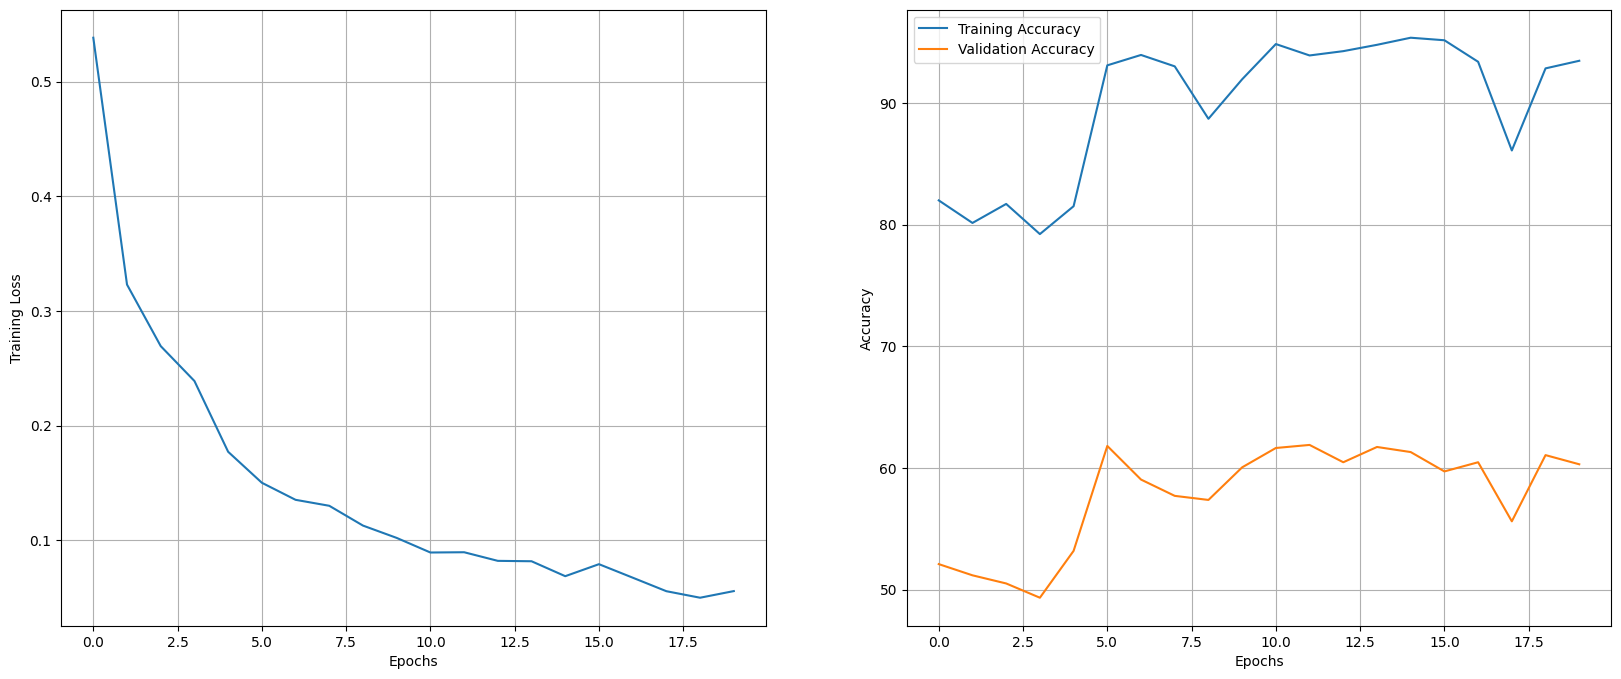

100%|██████████| 2400/2400 [01:12<00:00, 32.96it/s]


Epoch [71/100], Loss: 0.05632225925266276


100%|██████████| 2400/2400 [00:20<00:00, 114.55it/s]


Accuracy of the network on the 2400 train images: 95.9375


100%|██████████| 597/597 [00:07<00:00, 84.23it/s] 


Accuracy of the network on the 597 validation images: 62.814070351758794


100%|██████████| 2400/2400 [01:11<00:00, 33.78it/s]


Epoch [72/100], Loss: 0.054367957346173744


100%|██████████| 2400/2400 [00:23<00:00, 101.67it/s]


Accuracy of the network on the 2400 train images: 95.60416666666667


100%|██████████| 597/597 [00:07<00:00, 77.83it/s] 


Accuracy of the network on the 597 validation images: 62.311557788944725


100%|██████████| 2400/2400 [01:14<00:00, 32.06it/s]


Epoch [73/100], Loss: 0.048344709114182184


100%|██████████| 2400/2400 [00:22<00:00, 106.81it/s]


Accuracy of the network on the 2400 train images: 95.04166666666667


100%|██████████| 597/597 [00:07<00:00, 76.28it/s] 


Accuracy of the network on the 597 validation images: 61.139028475711896


100%|██████████| 2400/2400 [01:15<00:00, 31.77it/s]


Epoch [74/100], Loss: 0.044697956201500716


100%|██████████| 2400/2400 [00:22<00:00, 108.64it/s]


Accuracy of the network on the 2400 train images: 96.79166666666667


100%|██████████| 597/597 [00:07<00:00, 80.90it/s] 


Accuracy of the network on the 597 validation images: 62.47906197654942


100%|██████████| 2400/2400 [01:15<00:00, 31.92it/s]


Epoch [75/100], Loss: 0.05748265112193708


100%|██████████| 2400/2400 [00:22<00:00, 105.68it/s]


Accuracy of the network on the 2400 train images: 97.20833333333333


100%|██████████| 597/597 [00:07<00:00, 78.75it/s] 


Accuracy of the network on the 597 validation images: 65.07537688442211


100%|██████████| 2400/2400 [01:16<00:00, 31.45it/s]


Epoch [76/100], Loss: 0.04844319309466809


100%|██████████| 2400/2400 [00:22<00:00, 109.03it/s]


Accuracy of the network on the 2400 train images: 95.27083333333333


100%|██████████| 597/597 [00:07<00:00, 81.72it/s] 


Accuracy of the network on the 597 validation images: 62.981574539363486


100%|██████████| 2400/2400 [01:14<00:00, 32.11it/s]


Epoch [77/100], Loss: 0.04632435896008063


100%|██████████| 2400/2400 [00:21<00:00, 109.69it/s]


Accuracy of the network on the 2400 train images: 94.91666666666667


100%|██████████| 597/597 [00:07<00:00, 82.95it/s] 


Accuracy of the network on the 597 validation images: 65.15912897822446


100%|██████████| 2400/2400 [01:15<00:00, 31.78it/s]


Epoch [78/100], Loss: 0.04341219099701524


100%|██████████| 2400/2400 [00:22<00:00, 107.39it/s]


Accuracy of the network on the 2400 train images: 93.33333333333333


100%|██████████| 597/597 [00:07<00:00, 81.82it/s] 


Accuracy of the network on the 597 validation images: 59.212730318257954


100%|██████████| 2400/2400 [01:15<00:00, 31.88it/s]


Epoch [79/100], Loss: 0.045553704597417526


100%|██████████| 2400/2400 [00:22<00:00, 106.90it/s]


Accuracy of the network on the 2400 train images: 91.33333333333333


100%|██████████| 597/597 [00:07<00:00, 81.65it/s] 


Accuracy of the network on the 597 validation images: 58.12395309882747


100%|██████████| 2400/2400 [01:19<00:00, 30.20it/s]


Epoch [80/100], Loss: 0.03869334867982232


100%|██████████| 2400/2400 [00:22<00:00, 106.87it/s]


Accuracy of the network on the 2400 train images: 92.0625


100%|██████████| 597/597 [00:07<00:00, 79.08it/s] 

Accuracy of the network on the 597 validation images: 58.45896147403685


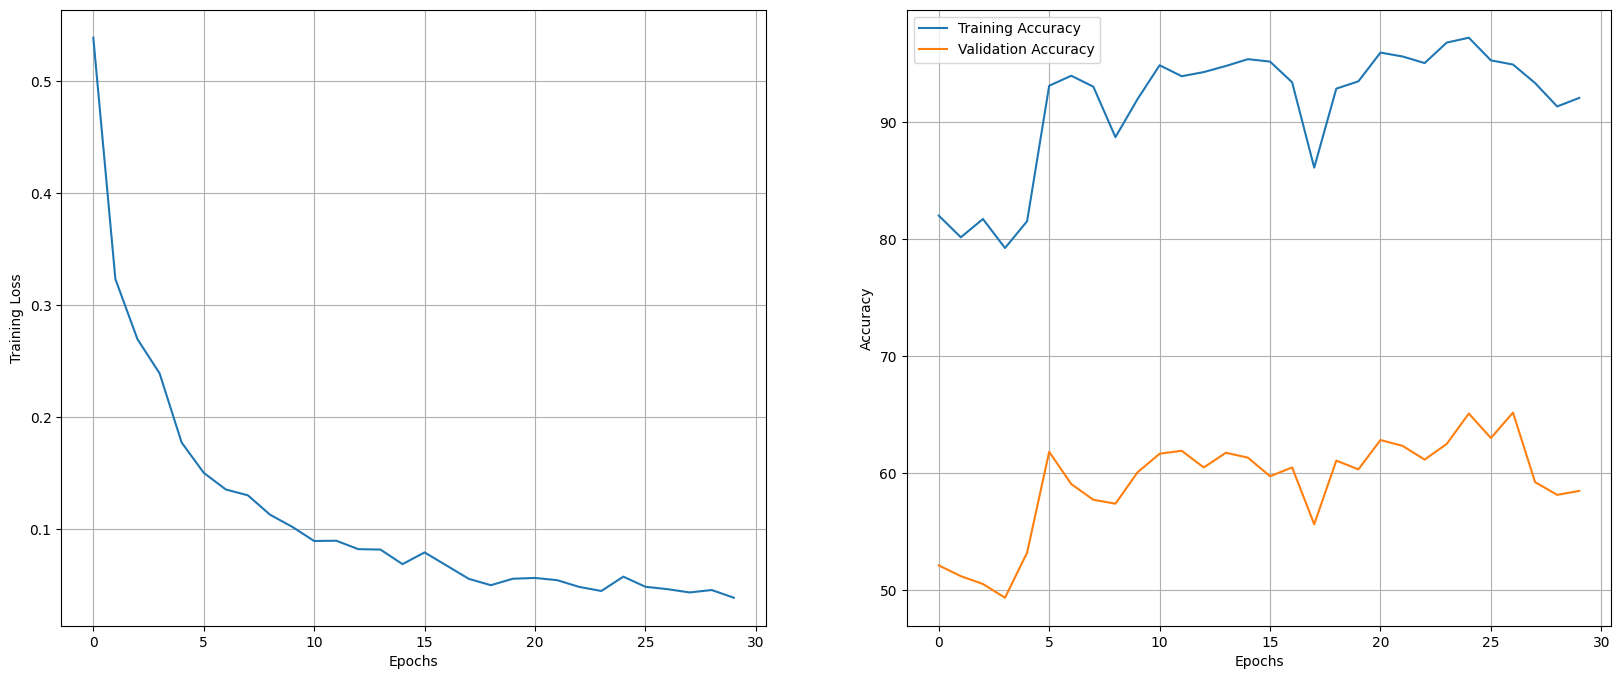

100%|██████████| 2400/2400 [01:21<00:00, 29.52it/s]


Epoch [81/100], Loss: 0.03815284756819857


100%|██████████| 2400/2400 [00:23<00:00, 101.32it/s]


Accuracy of the network on the 2400 train images: 93.60416666666667


100%|██████████| 597/597 [00:07<00:00, 76.55it/s] 


Accuracy of the network on the 597 validation images: 57.370184254606365


100%|██████████| 2400/2400 [01:21<00:00, 29.51it/s]


Epoch [82/100], Loss: 0.03588632101371116


100%|██████████| 2400/2400 [00:23<00:00, 103.19it/s]


Accuracy of the network on the 2400 train images: 92.83333333333333


100%|██████████| 597/597 [00:07<00:00, 82.32it/s] 


Accuracy of the network on the 597 validation images: 58.37520938023451


100%|██████████| 2400/2400 [01:15<00:00, 31.60it/s]


Epoch [83/100], Loss: 0.03684004321611374


100%|██████████| 2400/2400 [00:22<00:00, 107.71it/s]


Accuracy of the network on the 2400 train images: 95.29166666666667


100%|██████████| 597/597 [00:07<00:00, 81.43it/s] 


Accuracy of the network on the 597 validation images: 60.301507537688444


100%|██████████| 2400/2400 [01:15<00:00, 31.82it/s]


Epoch [84/100], Loss: 0.036713650984175485


100%|██████████| 2400/2400 [00:22<00:00, 109.03it/s]


Accuracy of the network on the 2400 train images: 93.22916666666667


100%|██████████| 597/597 [00:07<00:00, 82.29it/s] 


Accuracy of the network on the 597 validation images: 57.70519262981575


100%|██████████| 2400/2400 [01:15<00:00, 31.94it/s]


Epoch [85/100], Loss: 0.035851831284519346


100%|██████████| 2400/2400 [00:23<00:00, 103.82it/s]


Accuracy of the network on the 2400 train images: 93.20833333333333


100%|██████████| 597/597 [00:07<00:00, 82.06it/s] 


Accuracy of the network on the 597 validation images: 60.301507537688444


100%|██████████| 2400/2400 [01:14<00:00, 32.09it/s]


Epoch [86/100], Loss: 0.042682860960572576


100%|██████████| 2400/2400 [00:22<00:00, 108.18it/s]


Accuracy of the network on the 2400 train images: 94.02083333333333


100%|██████████| 597/597 [00:07<00:00, 78.75it/s] 


Accuracy of the network on the 597 validation images: 57.78894472361809


100%|██████████| 2400/2400 [01:14<00:00, 32.04it/s]


Epoch [87/100], Loss: 0.030994444759105975


100%|██████████| 2400/2400 [00:22<00:00, 108.23it/s]


Accuracy of the network on the 2400 train images: 96.97916666666667


100%|██████████| 597/597 [00:07<00:00, 81.90it/s] 


Accuracy of the network on the 597 validation images: 62.981574539363486


100%|██████████| 2400/2400 [01:17<00:00, 31.06it/s]


Epoch [88/100], Loss: 0.01700640509505809


100%|██████████| 2400/2400 [00:22<00:00, 107.39it/s]


Accuracy of the network on the 2400 train images: 93.27083333333333


100%|██████████| 597/597 [00:07<00:00, 77.99it/s] 


Accuracy of the network on the 597 validation images: 57.03517587939699


100%|██████████| 2400/2400 [01:18<00:00, 30.62it/s]


Epoch [89/100], Loss: 0.04129132279903917


100%|██████████| 2400/2400 [00:22<00:00, 106.14it/s]


Accuracy of the network on the 2400 train images: 95.4375


100%|██████████| 597/597 [00:07<00:00, 80.82it/s] 


Accuracy of the network on the 597 validation images: 61.30653266331658


100%|██████████| 2400/2400 [01:19<00:00, 30.20it/s]


Epoch [90/100], Loss: 0.03476130864548323


100%|██████████| 2400/2400 [00:22<00:00, 107.81it/s]


Accuracy of the network on the 2400 train images: 94.4375


100%|██████████| 597/597 [00:07<00:00, 75.42it/s] 


Accuracy of the network on the 597 validation images: 59.12897822445561


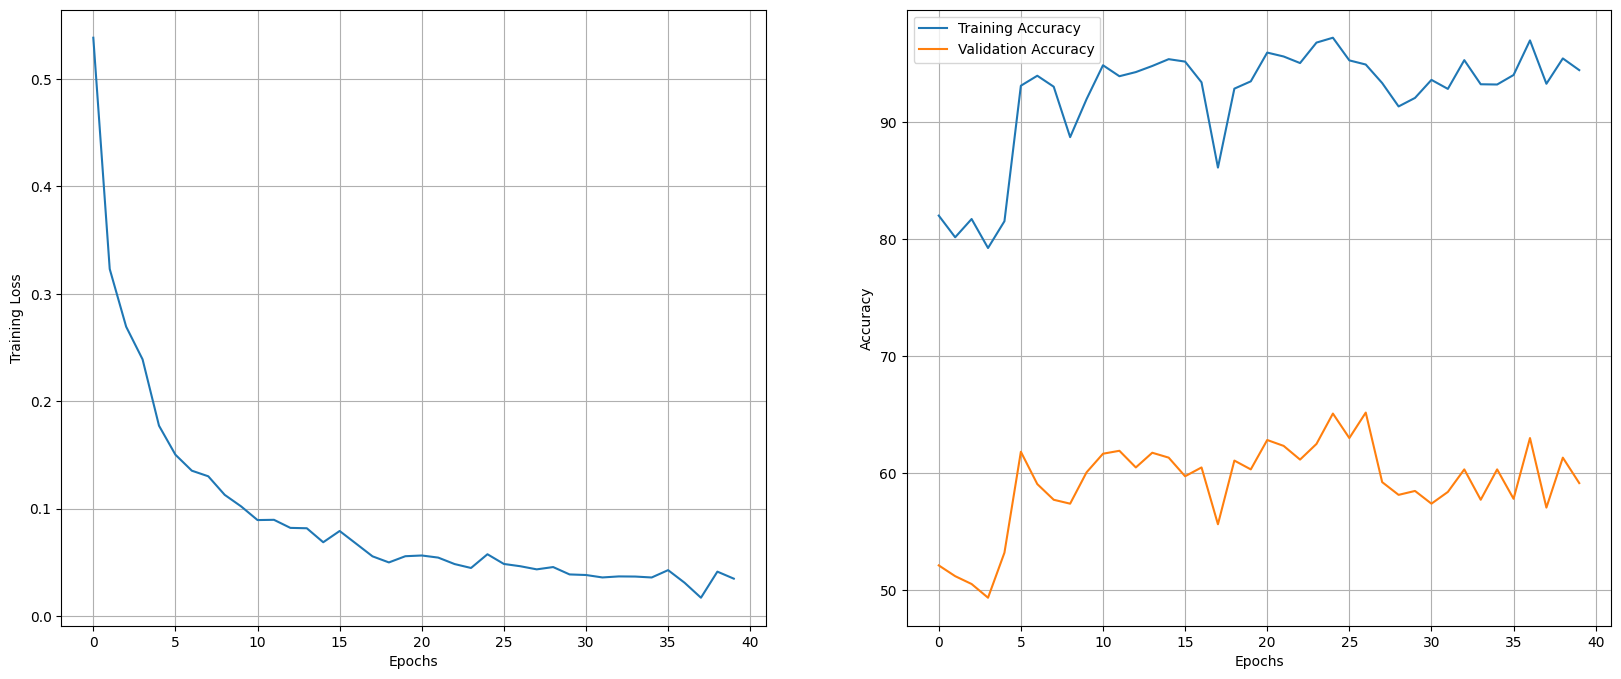

100%|██████████| 2400/2400 [01:18<00:00, 30.52it/s]


Epoch [91/100], Loss: 0.02962810290698162


100%|██████████| 2400/2400 [00:23<00:00, 100.64it/s]


Accuracy of the network on the 2400 train images: 89.4375


100%|██████████| 597/597 [00:06<00:00, 88.25it/s] 


Accuracy of the network on the 597 validation images: 58.040201005025125


100%|██████████| 2400/2400 [01:10<00:00, 34.03it/s]


Epoch [92/100], Loss: 0.03126257151064649


100%|██████████| 2400/2400 [00:20<00:00, 116.66it/s]


Accuracy of the network on the 2400 train images: 95.625


100%|██████████| 597/597 [00:06<00:00, 86.50it/s] 


Accuracy of the network on the 597 validation images: 61.30653266331658


100%|██████████| 2400/2400 [01:10<00:00, 33.88it/s]


Epoch [93/100], Loss: 0.027041864832291575


100%|██████████| 2400/2400 [00:20<00:00, 116.67it/s]


Accuracy of the network on the 2400 train images: 94.29166666666667


100%|██████████| 597/597 [00:06<00:00, 86.10it/s] 


Accuracy of the network on the 597 validation images: 58.710217755443885


100%|██████████| 2400/2400 [01:11<00:00, 33.56it/s]


Epoch [94/100], Loss: 0.03155775740057218


100%|██████████| 2400/2400 [00:20<00:00, 114.98it/s]


Accuracy of the network on the 2400 train images: 96.52083333333333


100%|██████████| 597/597 [00:07<00:00, 84.25it/s] 


Accuracy of the network on the 597 validation images: 62.06030150753769


100%|██████████| 2400/2400 [01:16<00:00, 31.43it/s]


Epoch [95/100], Loss: 0.026687789659128356


100%|██████████| 2400/2400 [00:20<00:00, 116.00it/s]


Accuracy of the network on the 2400 train images: 93.85416666666667


100%|██████████| 597/597 [00:07<00:00, 77.33it/s] 


Accuracy of the network on the 597 validation images: 56.53266331658291


100%|██████████| 2400/2400 [01:11<00:00, 33.73it/s]


Epoch [96/100], Loss: 0.03206018005132547


100%|██████████| 2400/2400 [00:22<00:00, 105.49it/s]


Accuracy of the network on the 2400 train images: 95.60416666666667


100%|██████████| 597/597 [00:07<00:00, 75.87it/s] 


Accuracy of the network on the 597 validation images: 62.814070351758794


100%|██████████| 2400/2400 [01:15<00:00, 31.96it/s]


Epoch [97/100], Loss: 0.018093546732842723


100%|██████████| 2400/2400 [00:22<00:00, 106.88it/s]


Accuracy of the network on the 2400 train images: 93.95833333333333


100%|██████████| 597/597 [00:07<00:00, 78.65it/s] 


Accuracy of the network on the 597 validation images: 57.95644891122278


100%|██████████| 2400/2400 [01:15<00:00, 31.71it/s]


Epoch [98/100], Loss: 0.03769859093598595


100%|██████████| 2400/2400 [00:22<00:00, 107.04it/s]


Accuracy of the network on the 2400 train images: 96.79166666666667


100%|██████████| 597/597 [00:07<00:00, 80.36it/s] 


Accuracy of the network on the 597 validation images: 62.06030150753769


100%|██████████| 2400/2400 [01:18<00:00, 30.66it/s]


Epoch [99/100], Loss: 0.026577524712848848


100%|██████████| 2400/2400 [00:23<00:00, 102.03it/s]


Accuracy of the network on the 2400 train images: 96.10416666666667


100%|██████████| 597/597 [00:07<00:00, 82.46it/s] 


Accuracy of the network on the 597 validation images: 60.80402010050251


100%|██████████| 2400/2400 [01:21<00:00, 29.48it/s]


Epoch [100/100], Loss: 0.024339066845697234


100%|██████████| 2400/2400 [00:23<00:00, 102.24it/s]


Accuracy of the network on the 2400 train images: 94.16666666666667


100%|██████████| 597/597 [00:07<00:00, 76.28it/s] 

Accuracy of the network on the 597 validation images: 58.12395309882747


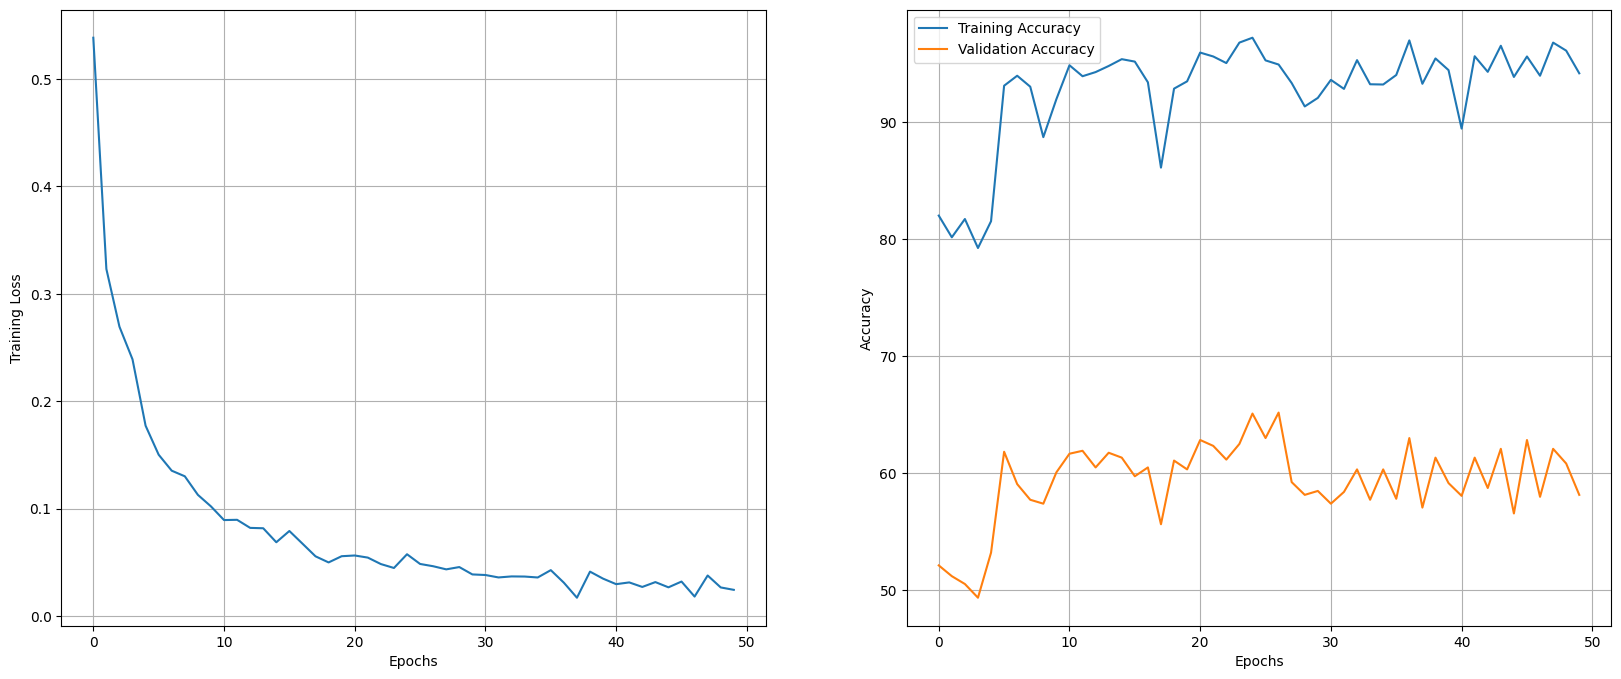

100%|██████████| 2897/2897 [00:38<00:00, 75.73it/s] 

Accuracy of the network on the 2897 test images: 58.7159130134622


58.7159130134622

In [18]:
checkVariables = torch.load('2048_checkModel_49.pth')
checkModel = models.resnet50()
checkModel.fc = nn.Sequential(
    nn.Linear(checkModel.fc.in_features, checkModel.fc.in_features),
    nn.ReLU(),
    nn.Linear(checkModel.fc.in_features, 200),
)
checkModel.load_state_dict(checkVariables)
criterion = nn.CrossEntropyLoss()
 
checkModel.to(device)

torch.cuda.empty_cache()
gc.collect()

training_accuracy = []
training_loss = []
validation_accuracy = []

# Number of epochs
num_epochs = 50
base=50
optimizer = optim.Adam(params=checkModel.parameters(), lr=1e-4, weight_decay=0)

for epoch in range(base, num_epochs+base):
    checkModel.train()

    running_loss = 0    
    for input_data, labels in tqdm.tqdm(TrainLoader, total=len(TrainLoader)):
        # Forward pass
        labels, input_data = labels.to(device), input_data.to(device)
        output = checkModel(input_data)
        
        # Compute loss
        loss = criterion(output, labels.long())
        running_loss += loss.item()
        # Backward pass
        optimizer.zero_grad()  # Zero the gradients
        loss.backward()  # Compute gradients
        optimizer.step()  # Update weights
    # scheduler.step(running_loss)  # Update learning rate
        
    # Print training progress
    print(f'Epoch [{epoch + 1}/{num_epochs + base}], Loss: {running_loss / len(TrainLoader)}')
    training_loss.append(running_loss / len(TrainLoader))

    training_accuracy.append(calculate_accuracy(checkModel, TrainLoader, data_type='train'))
    validation_accuracy.append(calculate_accuracy(checkModel, ValidationLoader, data_type='validation'))
    

    if (epoch + 1) % 10 == 0:
        fig, ax = plt.subplots(1, 2, figsize=(20, 8))
        ax[0].plot(range(len(training_loss)), training_loss)
        ax[1].plot(range(len(training_accuracy)), training_accuracy, label='Training Accuracy')
        ax[1].plot(range(len(validation_accuracy)), validation_accuracy, label='Validation Accuracy')
        ax[1].grid()
        ax[0].grid()
        ax[0].set_xlabel('Epochs')
        ax[0].set_ylabel('Training Loss')
        ax[1].set_xlabel('Epochs')
        ax[1].set_ylabel('Accuracy')
        ax[1].legend()
        plt.show()
        torch.save(checkModel.state_dict(), f"checkModel_{epoch + base}.pth")
calculate_accuracy(checkModel, TestLoader, data_type='test')